In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.collections import LineCollection
from sklearn import preprocessing
from sklearn import decomposition
import scipy.stats as st
from scipy.stats import ks_2samp
import matplotlib.lines as mlines
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score,confusion_matrix

In [2]:
def display_circles(pcs, n_comp, pca, axis_ranks, labels=None, label_rotation=0, lims=None):
    for d1, d2 in axis_ranks: # On affiche les 3 premiers plans factoriels, donc les 6 premières composantes
        if d2 < n_comp:

            # initialisation de la figure
            fig, ax = plt.subplots(figsize=(10,8))

            # détermination des limites du graphique
            if lims is not None :
                xmin, xmax, ymin, ymax = lims
            elif pcs.shape[1] < 30 :
                xmin, xmax, ymin, ymax = -1, 1, -1, 1
            else :
                xmin, xmax, ymin, ymax = min(pcs[d1,:]), max(pcs[d1,:]), min(pcs[d2,:]), max(pcs[d2,:])

            # affichage des flèches
            # s'il y a plus de 30 flèches, on n'affiche pas le triangle à leur extrémité
            if pcs.shape[1] < 30 :
                plt.quiver(np.zeros(pcs.shape[1]), np.zeros(pcs.shape[1]),
                   pcs[d1,:], pcs[d2,:], 
                   angles='xy', scale_units='xy', scale=1, color="grey")
                # (voir la doc : https://matplotlib.org/api/_as_gen/matplotlib.pyplot.quiver.html)
            else:
                lines = [[[0,0],[x,y]] for x,y in pcs[[d1,d2]].T]
                ax.add_collection(LineCollection(lines, axes=ax, alpha=.1, color='black'))
            
            # affichage des noms des variables  
            if labels is not None:  
                for i,(x, y) in enumerate(pcs[[d1,d2]].T):
                    if x >= xmin and x <= xmax and y >= ymin and y <= ymax :
                        plt.text(x, y, labels[i], fontsize='14', ha='center', va='center', rotation=label_rotation, color="blue", alpha=0.5)
            
            # affichage du cercle
            circle = plt.Circle((0,0), 1, facecolor='none', edgecolor='b')
            plt.gca().add_artist(circle)

            # définition des limites du graphique
            plt.xlim(xmin, xmax)
            plt.ylim(ymin, ymax)
        
            # affichage des lignes horizontales et verticales
            plt.plot([-1, 1], [0, 0], color='grey', ls='--')
            plt.plot([0, 0], [-1, 1], color='grey', ls='--')

            # nom des axes, avec le pourcentage d'inertie expliqué
            plt.xlabel('F{} ({}%)'.format(d1+1, round(100*pca.explained_variance_ratio_[d1],1)))
            plt.ylabel('F{} ({}%)'.format(d2+1, round(100*pca.explained_variance_ratio_[d2],1)))

            plt.title("Cercle des corrélations (F{} et F{})".format(d1+1, d2+1))
            #plt.show(block=False)
            plt.draw()
        
def display_factorial_planes(X_projected, n_comp, pca, axis_ranks, labels=None,clusters=None, alpha=1, illustrative_var=None):
    for d1,d2 in axis_ranks:
        if d2 < n_comp:
 
            # initialisation de la figure       
            fig = plt.figure(figsize=(30,22))
        
            # affichage des points
            if illustrative_var is None:
                plt.scatter(X_projected[:, d1], X_projected[:, d2], alpha=alpha, color='w',marker = '*',s=5)
            else:
                illustrative_var = np.array(illustrative_var)
                for value in np.unique(illustrative_var):
                    selected = np.where(illustrative_var == value)
                    plt.scatter(X_projected[selected, d1], X_projected[selected, d2], alpha=alpha, label=value)
                plt.legend()

            # affichage des labels des points
            if labels is not None:
                clusters_color = {1 : 'blue', 0 : 'red'}
                for i,(x,y) in enumerate(X_projected[:,[d1,d2]]):
                    plt.text(x, y, labels[i],color=clusters_color[clusters[i]],
                              fontsize='20', ha='center',va='center') 
                
            # détermination des limites du graphique
            boundary = np.max(np.abs(X_projected[:, [d1,d2]])) * 1.1
            plt.xlim([-boundary,boundary])
            plt.ylim([-boundary,boundary])
        
            # affichage des lignes horizontales et verticales
            #plt.plot([-100, 100], [0, 0], color='grey', ls='--')
            #plt.plot([0, 0], [-100, 100], color='grey', ls='--')

            # nom des axes, avec le pourcentage d'inertie expliqué
            plt.xlabel('F{} ({}%)'.format(d1+1, round(100*pca.explained_variance_ratio_[d1],1)),fontsize=25)
            plt.ylabel('F{} ({}%)'.format(d2+1, round(100*pca.explained_variance_ratio_[d2],1)),fontsize=25)

            plt.title("Projection des individus (sur F{} et F{})".format(d1+1, d2+1),fontsize=35)
            #plt.show(block=False)
            plt.draw()

def display_scree_plot(pca):
    scree = pca.explained_variance_ratio_*100
    plt.bar(np.arange(len(scree))+1, scree)
    plt.plot(np.arange(len(scree))+1, scree.cumsum(),c="red",marker='o')
    plt.xlabel("rang de l'axe d'inertie")
    plt.ylabel("pourcentage d'inertie")
    plt.title("Eboulis des valeurs propres")
    #plt.show(block=False)
    plt.draw()

In [3]:
notes = pd.read_csv("notes.csv")#example
#print(notes.shape)
notes

,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length
0,True,171.81,104.86,104.95,4.52,2.89,112.83
1,True,171.67,103.74,103.70,4.01,2.87,113.29
2,True,171.83,103.76,103.76,4.40,2.88,113.84
3,True,171.80,103.78,103.65,3.73,3.12,113.63
4,True,172.05,103.70,103.75,5.04,2.27,113.55
...,...,...,...,...,...,...,...
165,False,172.11,104.23,104.45,5.24,3.58,111.78
166,False,173.01,104.59,104.31,5.04,3.05,110.91
167,False,172.47,104.27,104.10,4.88,3.33,110.68
168,False,171.82,103.97,103.88,4.73,3.55,111.87


In [4]:
print("nombre de NaN :")
print(notes.isna().sum())

nombre de NaN :
is_genuine      0
diagonal        0
height_left     0
height_right    0
margin_low      0
margin_up       0
length          0
dtype: int64


In [5]:
notes.info()
#pas de valeur manquantes, 6 colonnes de float et 1 colonne de boleen

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 170 entries, 0 to 169
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   is_genuine    170 non-null    bool   
 1   diagonal      170 non-null    float64
 2   height_left   170 non-null    float64
 3   height_right  170 non-null    float64
 4   margin_low    170 non-null    float64
 5   margin_up     170 non-null    float64
 6   length        170 non-null    float64
dtypes: bool(1), float64(6)
memory usage: 8.3 KB


In [6]:
notes.describe(include = 'all')
#pas de valeurs aberantes

,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length
count,170,170.000000,170.000000,170.000000,170.000000,170.000000,170.000000
unique,2,NaN,NaN,NaN,NaN,NaN,NaN
top,True,NaN,NaN,NaN,NaN,NaN,NaN
freq,100,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,171.940588,104.066353,103.928118,4.612118,3.170412,112.570412
std,NaN,0.305768,0.298185,0.330980,0.702103,0.236361,0.924448
min,NaN,171.040000,103.230000,103.140000,3.540000,2.270000,109.970000
25%,NaN,171.730000,103.842500,103.690000,4.050000,3.012500,111.855000
50%,NaN,171.945000,104.055000,103.950000,4.450000,3.170000,112.845000
75%,NaN,172.137500,104.287500,104.170000,5.127500,3.330000,113.287500


In [7]:
notes.columns

Index(['is_genuine', 'diagonal', 'height_left', 'height_right', 'margin_low',
       'margin_up', 'length'],
      dtype='object')

In [8]:
notes['is_genuine'].value_counts()

True     100
False     70
Name: is_genuine, dtype: int64

In [9]:
np.size(notes)

1190

In [10]:
def ana(toto):
    dataset = toto[['diagonal', 'height_left', 'height_right', 'margin_low', 'margin_up', 'length']].copy()
    print ("La taille de notre tableau de mesures des billets est de : ", dataset.shape," (lignes,colonnes).")           
    print ("--------------------------------------------------------------------")
    for column in dataset:
        print(column," moyenne:", round(dataset[column].mean(),2),"médiane:", round(dataset[column].median(),2),"écart-type:",round(dataset[column].std(ddof=1),2))

In [11]:
ana(notes)

La taille de notre tableau de mesures des billets est de :  (170, 6)  (lignes,colonnes).
--------------------------------------------------------------------
diagonal  moyenne: 171.94 médiane: 171.94 écart-type: 0.31
height_left  moyenne: 104.07 médiane: 104.06 écart-type: 0.3
height_right  moyenne: 103.93 médiane: 103.95 écart-type: 0.33
margin_low  moyenne: 4.61 médiane: 4.45 écart-type: 0.7
margin_up  moyenne: 3.17 médiane: 3.17 écart-type: 0.24
length  moyenne: 112.57 médiane: 112.84 écart-type: 0.92


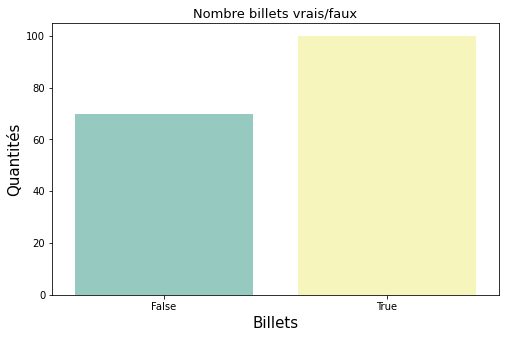

In [12]:
plt.rcParams["figure.figsize"]=[8,5]
plt.title("Nombre billets vrais/faux", fontsize=13)
sns.countplot(x='is_genuine',data=notes,palette="Set3")
plt.xlabel("Billets",fontsize=15)
plt.ylabel("Quantités",fontsize=15)
plt.draw()
#plt.savefig("comptage.jpg",bbox="tight")

True     100
False     70
Name: is_genuine, dtype: int64

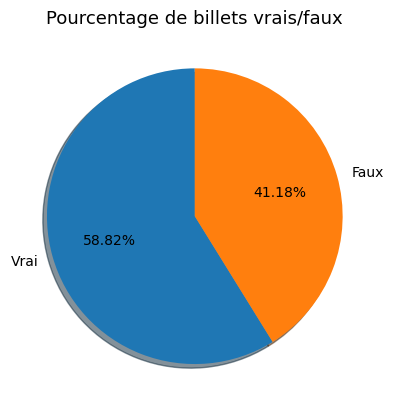

In [13]:
plt.style.use('default')
toto = notes.is_genuine.value_counts()
plt.title("Pourcentage de billets vrais/faux", fontsize=13)
plt.rcParams["figure.figsize"]=[5,5]
plt.pie(toto.values, labels=["Vrai","Faux"],autopct='%1.2f%%',shadow=True,startangle=90, textprops={'fontsize': 10})
plt.draw()
#plt.savefig("pourcentage.jpg",bbox="tight")
notes.is_genuine.value_counts()

In [14]:
notes.iloc[:,1:8].corr()
#corrélation négative entre 'margin_low' et 'length' indique que les valeurs 
#d'une variable tendent à augmenter lorsque celles de l'autre variable diminuent
#correlation moderee entre 'height_right'/'height_left' et 'margin_low'
#les plus correllees:
#height_left/height_right : 0.734390
#margin_low/length : -0.637352
#margin_up/length : -0.525284
#margin_low/height_right : 0.509375

,diagonal,height_left,height_right,margin_low,margin_up,length
diagonal,1.000000,0.319584,0.220418,-0.181020,-0.027366,0.080295
height_left,0.319584,1.000000,0.734390,0.424530,0.324788,-0.421387
height_right,0.220418,0.734390,1.000000,0.509375,0.366918,-0.417021
margin_low,-0.181020,0.424530,0.509375,1.000000,0.171113,-0.637352
margin_up,-0.027366,0.324788,0.366918,0.171113,1.000000,-0.525284
length,0.080295,-0.421387,-0.417021,-0.637352,-0.525284,1.000000


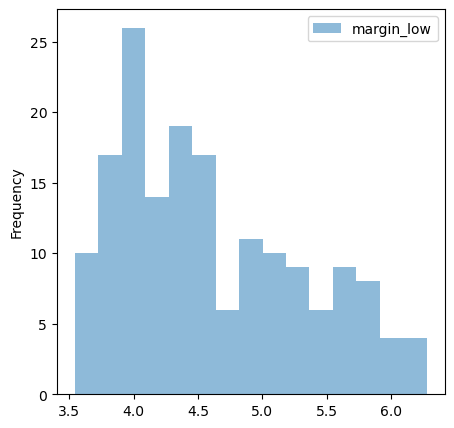

In [15]:
notes.iloc[:,4:5].plot(kind='hist', alpha=0.5, stacked=False, bins=15)
plt.draw()

la moyenne de la colonne  diagonal 171.94058823529414
la mediane de la colonne  diagonal 171.945
Ecart-type: 0.3048677743901313


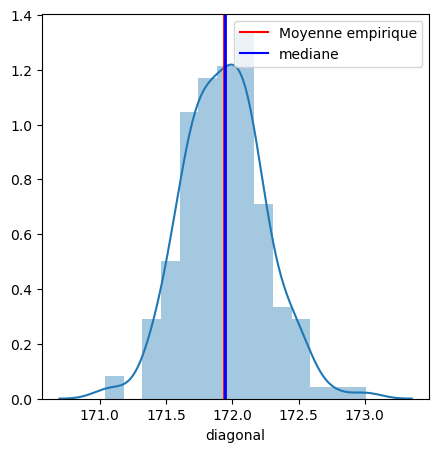

In [16]:
for column in notes.iloc[:,1:2]:
    print("la moyenne de la colonne ",column, notes[column].mean())
    print("la mediane de la colonne ",column, notes[column].median())
    print("Ecart-type:",notes[column].std(ddof=0))
    sns.distplot(notes[column])
    plt.axvline(notes[column].mean(), color='r', linewidth=2)
    plt.axvline(notes[column].median(), color='b', linewidth=2)
    plt.legend(handles=[mlines.Line2D([], [], color='red',markersize=15, label="Moyenne empirique"),mlines.Line2D([], [], color='blue',markersize=15, label=u"mediane")])
    plt.draw()
    plt.savefig("uni_diagonal.jpg",bbox="tight")
    #notes.boxplot(column=[column],by="is_genuine")
    #plt.show()

la moyenne de la colonne  margin_low 4.612117647058824
la mediane de la colonne  margin_low 4.45
Ecart-type: 0.7000346111067688


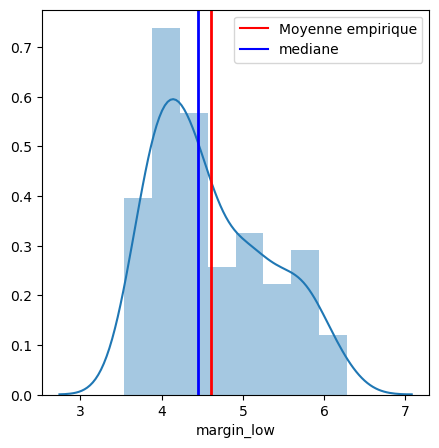

In [17]:
for column in notes.iloc[:,4:5]:
    print("la moyenne de la colonne ",column, notes[column].mean())
    print("la mediane de la colonne ",column, notes[column].median())
    print("Ecart-type:",notes[column].std(ddof=0))
    sns.distplot(notes[column])
    plt.axvline(notes[column].mean(), color='r', linewidth=2)
    plt.axvline(notes[column].median(), color='b', linewidth=2)
    plt.legend(handles=[mlines.Line2D([], [], color='red',markersize=15, label="Moyenne empirique"),mlines.Line2D([], [], color='blue',markersize=15, label=u"mediane")])
    plt.draw()
    plt.savefig("margin_low.jpg",bbox="tight")
    #notes.boxplot(column=[column],by="is_genuine")
    #plt.show()
        #semble bimodale

la moyenne de la colonne  length 112.57041176470587
la mediane de la colonne  length 112.845
Ecart-type: 0.9217249531575873


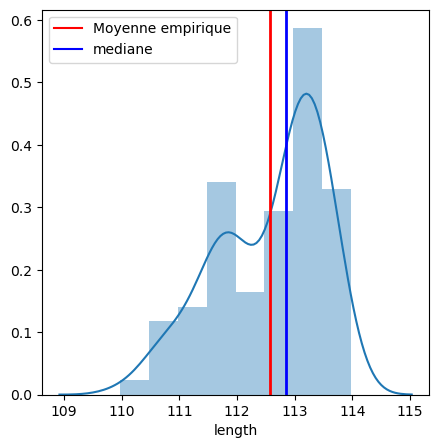

In [18]:
for column in notes.iloc[:,6:7]:
    print("la moyenne de la colonne ",column, notes[column].mean())
    print("la mediane de la colonne ",column, notes[column].median())
    print("Ecart-type:",notes[column].std(ddof=0))
    sns.distplot(notes[column])
    plt.axvline(notes[column].mean(), color='r', linewidth=2)
    plt.axvline(notes[column].median(), color='b', linewidth=2)
    plt.legend(handles=[mlines.Line2D([], [], color='red',markersize=15, label="Moyenne empirique"),mlines.Line2D([], [], color='blue',markersize=15, label=u"mediane")])
    plt.draw()
    plt.savefig("length.jpg",bbox="tight")
    #notes.boxplot(column=[column],by="is_genuine")
    #plt.show()
    #semble bimodale

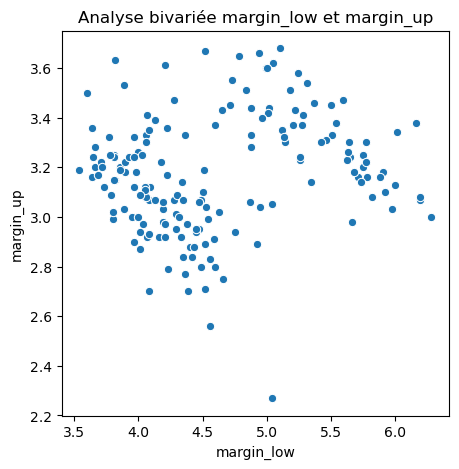

In [19]:
sns.scatterplot(x="margin_low", y="margin_up",data=notes)
plt.title('Analyse bivariée margin_low et margin_up')
plt.draw()
plt.savefig("biv_margin_low_up.jpg",bbox="tight")

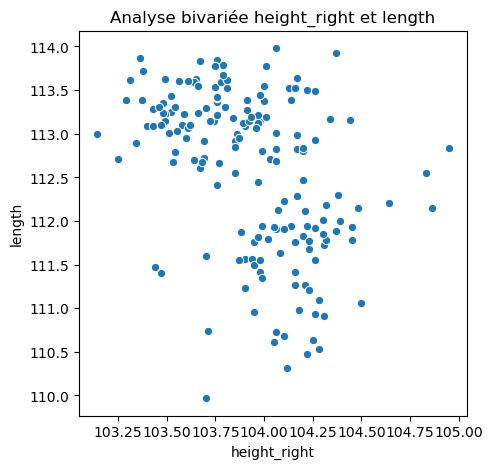

In [20]:
sns.scatterplot(x="height_right", y="length",data=notes)
plt.title('Analyse bivariée height_right et length')
plt.draw()
plt.savefig("biv_height_right_length.jpg",bbox="tight")

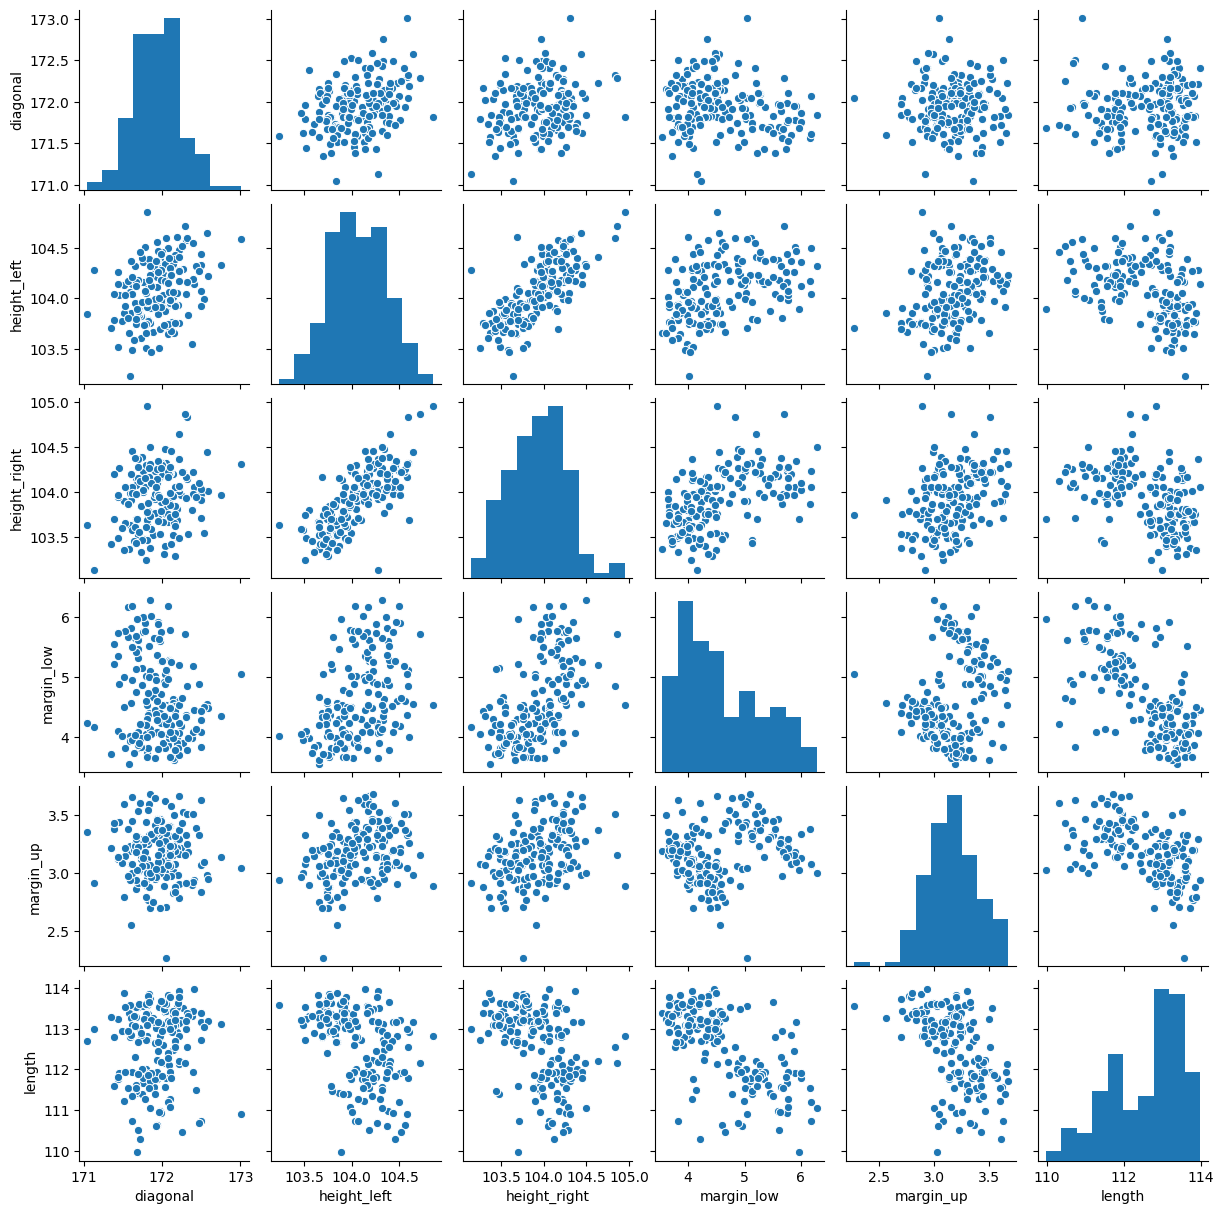

In [21]:
#sns.set(font_scale = 1.5)
sns.pairplot(notes.iloc[:,1:7], height=2)
#plt.savefig("pairplot.jpg",bbox="tight")

In [22]:
#sns.pairplot(notes, hue="is_genuine");

##Analyse en composantes principales de l'échantillon

In [23]:
notes.iloc[:,1:7]#visualisation des données nécessaires à l'ACP

,diagonal,height_left,height_right,margin_low,margin_up,length
0,171.81,104.86,104.95,4.52,2.89,112.83
1,171.67,103.74,103.70,4.01,2.87,113.29
2,171.83,103.76,103.76,4.40,2.88,113.84
3,171.80,103.78,103.65,3.73,3.12,113.63
4,172.05,103.70,103.75,5.04,2.27,113.55
...,...,...,...,...,...,...
165,172.11,104.23,104.45,5.24,3.58,111.78
166,173.01,104.59,104.31,5.04,3.05,110.91
167,172.47,104.27,104.10,4.88,3.33,110.68
168,171.82,103.97,103.88,4.73,3.55,111.87


##Analyse de l'éboulis des valeurs propres

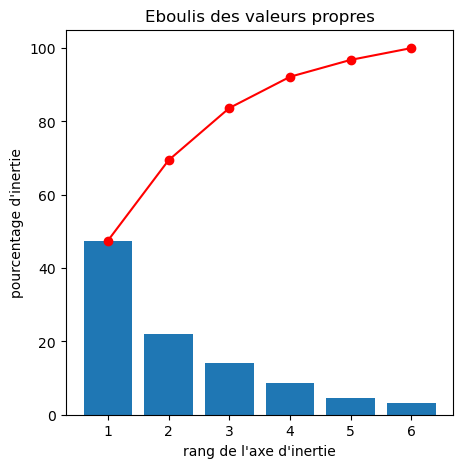

In [24]:
# choix du nombre de composantes à calculer
n_comp = 6

# selection des colonnes à prendre en compte dans l'ACP
data_pca = notes.iloc[:,1:7]

# préparation des données pour l'ACP
data_pca = data_pca.fillna(data_pca.mean()) # remplacer les valeurs inconnues par la moyenne de la variable
X = data_pca.values
names = notes.index # ou data.index pour avoir les intitulés
features = data_pca.columns

# Centrage et Réduction
std_scale = preprocessing.StandardScaler().fit(X)
X_scaled = std_scale.transform(X)
#X_scaled = preprocessing.StandardScaler().fit_transform(X)

# Calcul des composantes principales
pca = decomposition.PCA(n_components=n_comp)
pca.fit(X_scaled)

# Eboulis des valeurs propres
display_scree_plot(pca)

plt.savefig("eboulis.jpg",bbox="tight")

In [25]:
#Proportion de la variance expliquée
print(pca.explained_variance_ratio_)
#La premiere composante contient 47.44 % de l'information disponible et disposons de 69.39% avec les deux premiers facteurs.

[0.47447921 0.21957106 0.14234524 0.08526295 0.04612822 0.03221331]


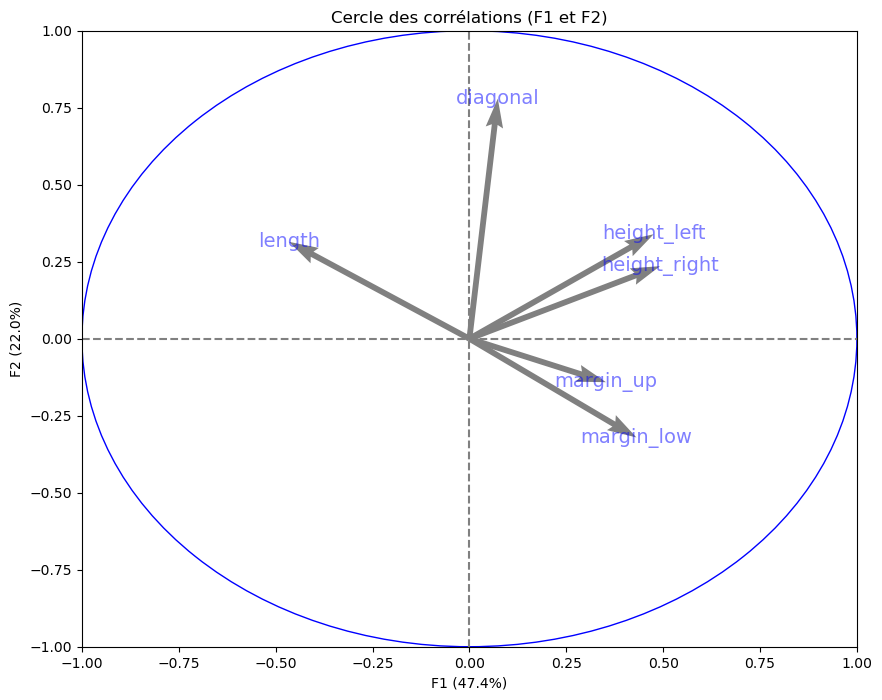

In [26]:
# Cercle des corrélations
pcs = pca.components_
display_circles(pcs, n_comp, pca, [(0,1)], labels = np.array(features))

plt.savefig("cercles.jpg",bbox="tight")

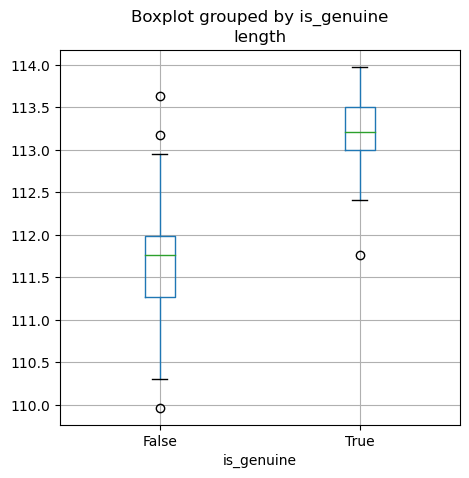

In [27]:
notes.boxplot(column="length",by="is_genuine")
plt.draw()

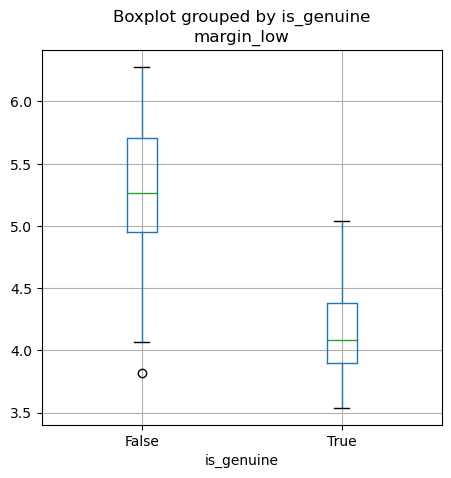

In [28]:
notes.boxplot(column="margin_low",by="is_genuine")
plt.draw()

##Représentation des individus par les plans factoriels

In [29]:
X_projected = pca.transform(X_scaled)

In [30]:
#Création du dataframe F_data pour contenir les données accumulées
df = pd.DataFrame(data=X_projected, columns=["F1", "F2", "F3", "F4", "F5", "F6"])
F_data = pd.concat([df, notes], axis=1).copy()
del df
F_data

,F1,F2,F3,F4,F5,F6,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length
0,2.153639,1.599709,1.787451,2.433465,0.699690,-1.267702,True,171.81,104.86,104.95,4.52,2.89,112.83
1,-2.110416,-0.526039,0.542563,0.344550,0.067440,-0.544601,True,171.67,103.74,103.70,4.01,2.87,113.29
2,-1.973152,-0.048102,0.858716,0.374812,-0.424886,0.080487,True,171.83,103.76,103.76,4.40,2.88,113.84
3,-2.059795,-0.089105,-0.531529,0.519548,-0.033267,-0.038261,True,171.80,103.78,103.65,3.73,3.12,113.63
4,-2.403180,0.412170,3.319507,-0.837043,-0.420151,-0.445099,True,172.05,103.70,103.75,5.04,2.27,113.55
...,...,...,...,...,...,...,...,...,...,...,...,...,...
165,2.478626,0.189974,-0.814598,0.107861,-0.899828,0.093078,False,172.11,104.23,104.45,5.24,3.58,111.78
166,2.585331,2.914472,0.586789,-2.183704,0.274577,-0.509206,False,173.01,104.59,104.31,5.04,3.05,110.91
167,2.067245,0.845602,-0.610282,-1.714172,0.116958,-0.504338,False,172.47,104.27,104.10,4.88,3.33,110.68
168,0.739257,-0.972965,-1.359772,-0.191736,-0.243557,0.211429,False,171.82,103.97,103.88,4.73,3.55,111.87


In [31]:
F_data.drop(['F3','F4','F5','F6'], axis = 1, inplace = True)
F_data['is_genuine'] = F_data['is_genuine'].replace({False:0 ,True:1})

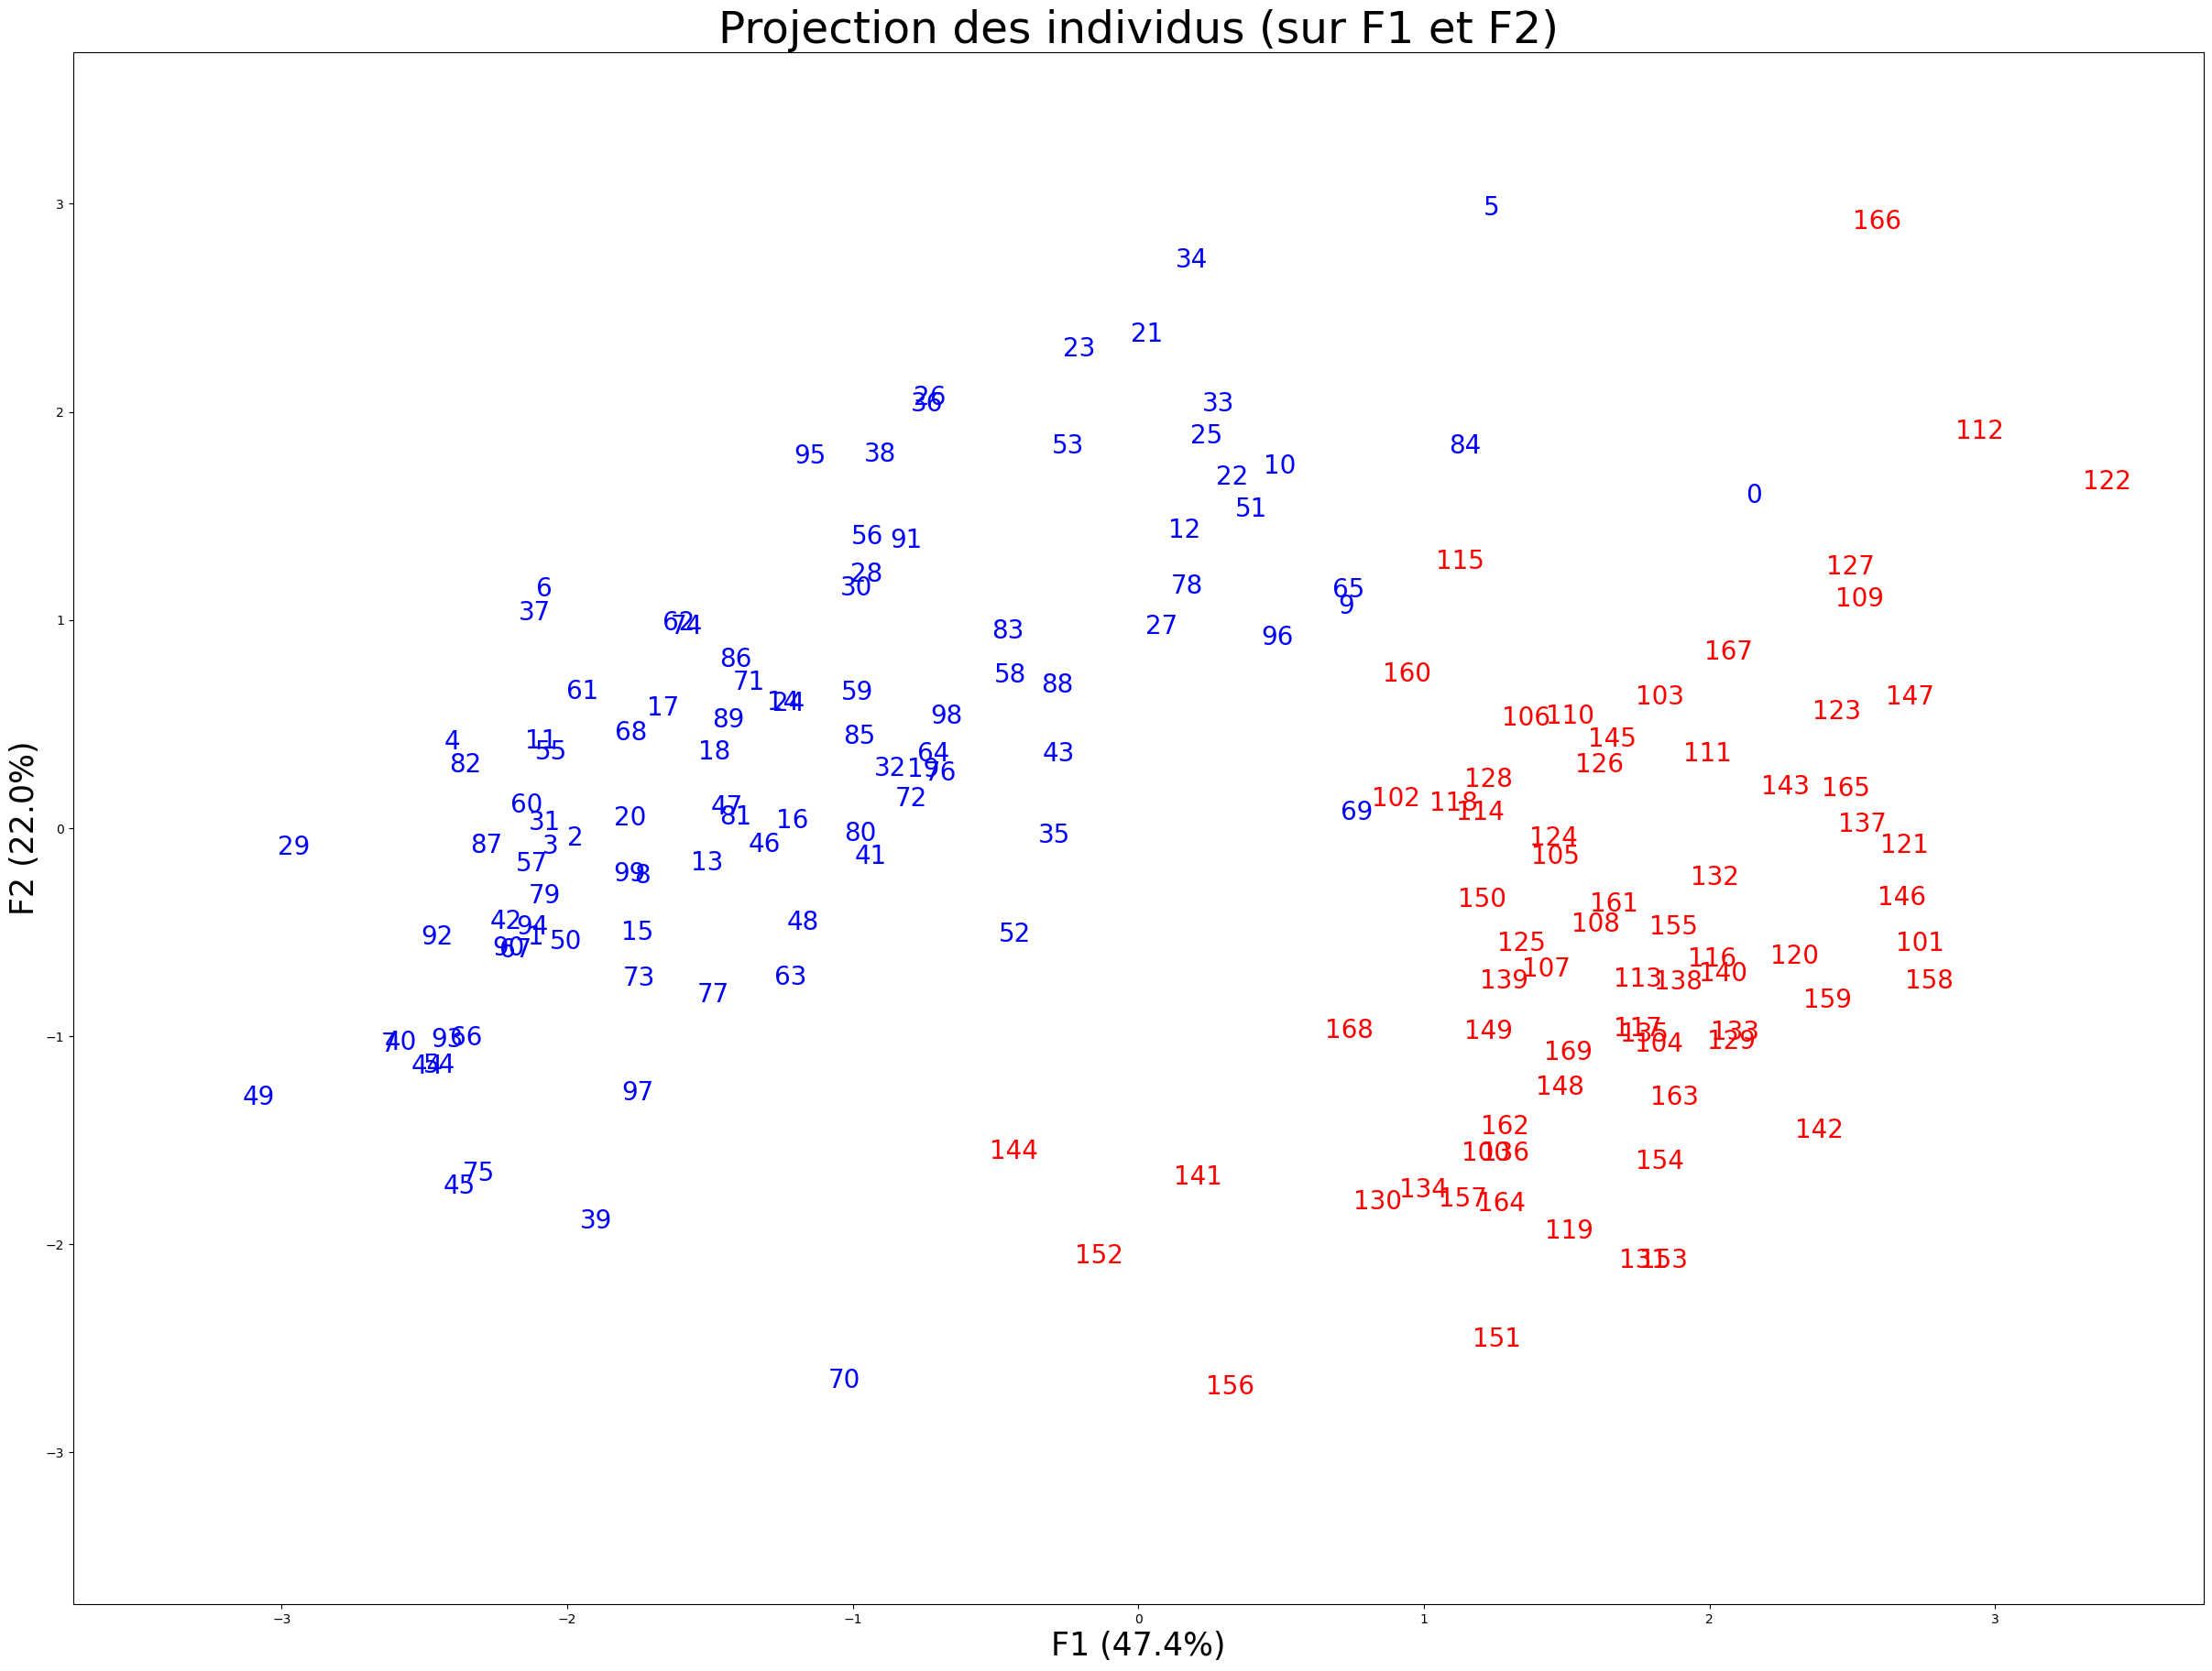

In [32]:
display_factorial_planes(X_projected, n_comp, pca, [(0,1)], labels = notes.index, clusters = notes.is_genuine)
plt.savefig("individus.jpg",bbox="tight")

##Contribution des individus dans l'inertie totale

In [33]:
contrib_it = np.sum((X_scaled)**2,axis=1)
ciit = (pd.DataFrame({'ID':names,'contrib_it': contrib_it}))
ciit.set_index('ID', inplace=True)
ciit = pd.concat([ciit, notes[['is_genuine']]], axis=1)
#ciit.sort_values(by='contrib_it').tail(60)['is_genuine'].value_counts()
ciit.sort_values(by='contrib_it')

,contrib_it,is_genuine
64,0.813929,True
98,0.878319,True
85,1.431664,True
76,1.435202,True
59,1.484454,True
...,...,...
39,15.052608,True
122,16.790944,False
4,18.039567,True
0,18.410598,True


In [34]:
ciit[ciit['is_genuine'] == False]['contrib_it'].sum()

482.5274186750297

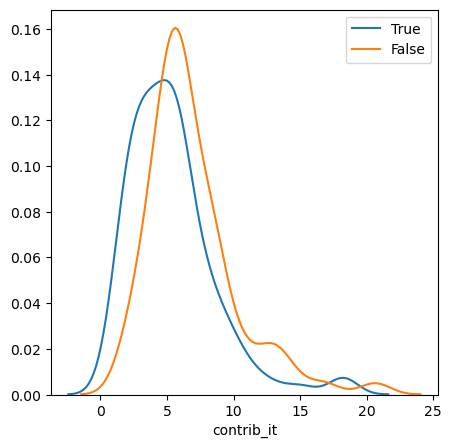

In [35]:
sns.distplot(ciit[ciit['is_genuine'] == True]['contrib_it'], hist = False, kde = True, label='True')
sns.distplot(ciit[ciit['is_genuine'] == False]['contrib_it'], hist = False, kde = True, label='False')
# Plot formatting
#plt.legend(prop={'size': 12})
#plt.title('Life Expectancy vs Continents')
#plt.xlabel('Life Exp (years)')
#plt.ylabel('Density')
plt.draw()

###Qualité de représentation des individus - COS2

In [36]:
p=notes.iloc[:,1:7].shape[1]
cos2 = (X_projected)**2
for j in range(p):
 cos2[:,j] = cos2[:,j]/contrib_it
qri = pd.DataFrame({'id':names,'COS2_1':cos2[:,0],'COS2_2':cos2[:,1],'COS2_3':cos2[:,2],'COS2_4':cos2[:,3],'COS2_5':cos2[:,4],'COS2_6':cos2[:,5]})
qri['id'] = qri['id'].astype(str)
#qri.set_index('id', inplace=True)
qri['veri_cos'] = qri.sum(axis=1)
qri.tail(50).sort_values(by='COS2_1').head(5)

,id,COS2_1,COS2_2,COS2_3,COS2_4,COS2_5,COS2_6,veri_cos
152,152,0.002987,0.681421,0.049759,0.234436,0.006731,0.024665,1.0
141,141,0.008766,0.567736,0.036327,0.286373,0.060685,0.040113,1.0
156,156,0.013014,0.919036,0.054389,0.005474,0.003080,0.005007,1.0
144,144,0.034747,0.443222,0.389281,0.004499,0.087170,0.041081,1.0
160,160,0.068742,0.042901,0.566870,0.295142,0.012319,0.014027,1.0


In [37]:
qri.iloc[:,1:7].sum().sum()

170.00000000000037

In [38]:
testo = qri[['COS2_1','COS2_2']].copy()
testo['COS2_F1F2'] = testo.sum(axis=1)
testo = pd.concat([testo, notes[['is_genuine']]], axis=1)
testo.sort_values(by='COS2_F1F2')

,COS2_1,COS2_2,COS2_F1F2,is_genuine
35,0.024786,0.000346,0.025132,True
43,0.038755,0.063289,0.102043,True
160,0.068742,0.042901,0.111643,False
88,0.023273,0.135767,0.159040,True
52,0.076673,0.106134,0.182807,True
...,...,...,...,...
154,0.542732,0.417831,0.960564,False
45,0.631308,0.331305,0.962613,True
46,0.962296,0.003343,0.965639,True
143,0.973456,0.007584,0.981040,False


In [39]:
#qualité de représentation du total des individus sur F1 et F2 en fonction qu ils soient vrais ou faux - COS2
mrif = (testo[testo['is_genuine'] == False]['COS2_F1F2'].values.sum())/testo[testo['is_genuine'] == False].shape[0]*100
print(round(mrif,2),'% est le pourcentage moyen de la qualité de représentation des faux billets.')
mriv = (testo[testo['is_genuine'] == True]['COS2_F1F2'].values.sum())/testo[testo['is_genuine'] == True].shape[0]*100
print(round(mriv,2),'% est le pourcentage moyen de la qualité de représentation des vrais billets.')

69.45 % est le pourcentage moyen de la qualité de représentation des faux billets.
68.18 % est le pourcentage moyen de la qualité de représentation des vrais billets.


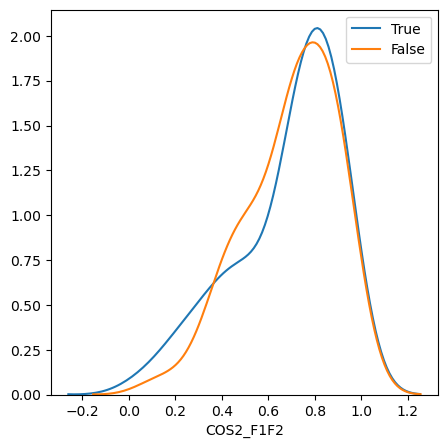

In [40]:
sns.distplot(testo[testo['is_genuine'] == True]['COS2_F1F2'], hist = False, kde = True, label='True')
sns.distplot(testo[testo['is_genuine'] == False]['COS2_F1F2'], hist = False, kde = True, label='False')
# Plot formatting
#plt.legend(prop={'size': 12})
#plt.title('Life Expectancy vs Continents')
#plt.xlabel('Life Exp (years)')
#plt.ylabel('Density')
plt.draw()

##Contributions des individus aux axes

In [41]:
n = notes.shape[0]
#valeur corrigée
eigval = pca.explained_variance_
print(eigval)

[2.86372065 1.32522178 0.85912514 0.51460481 0.27840703 0.19442354]


In [42]:
#contributions aux axes
p=notes.iloc[:,1:7].shape[1]
ctr = (X_projected)**2
for j in range(p):
 ctr[:,j] = ctr[:,j]/(n*eigval[j])

caa = pd.DataFrame({'id':notes.index,'CTR_1':ctr[:,0],'CTR_2':ctr[:,1]})
caa = pd.concat([caa, notes[['is_genuine']]], axis=1)
#caa.sort_values(by='CTR_1')
caa[['CTR_1','is_genuine']].sort_values(by='CTR_1')

,CTR_1,is_genuine
21,0.000002,True
27,0.000014,True
152,0.000038,False
12,0.000053,True
78,0.000059,True
...,...,...
158,0.015743,False
112,0.017845,False
29,0.017982,True
49,0.019505,True


In [43]:
caa.iloc[:,2:4].sort_values(by='CTR_2')

,CTR_2,is_genuine
137,0.000002,False
80,0.000003,True
31,0.000003,True
35,0.000005,True
16,0.000006,True
...,...,...
70,0.031331,True
156,0.032074,False
34,0.033106,True
166,0.037704,False


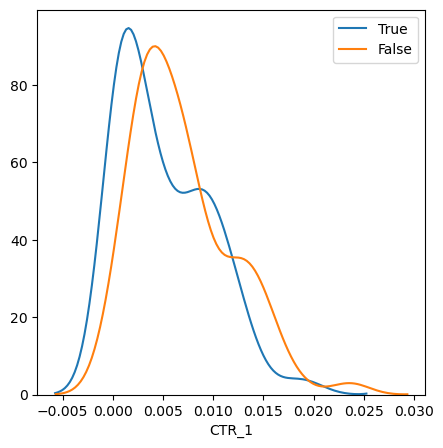

In [44]:
sns.distplot(caa[caa['is_genuine'] == True]['CTR_1'], hist = False, kde = True, label='True')
sns.distplot(caa[caa['is_genuine'] == False]['CTR_1'], hist = False, kde = True, label='False')
# Plot formatting
#plt.legend(prop={'size': 12})
#plt.title('Life Expectancy vs Continents')
#plt.xlabel('Life Exp (years)')
#plt.ylabel('Density')
plt.draw()

##Application de l'algorithme de classification KMeans.

In [45]:
X = notes.iloc[:,1:7].values

from sklearn.cluster import KMeans


kmeans = KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=2, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

# Réduire n'est ici pas nécessaire car les variables sont exprimées dans la même unité, ben non !!!
X_scaled = preprocessing.StandardScaler().fit_transform(X) #bis mais c pas grave

kmeans.fit(X_scaled)
#print(kmeans.cluster_centers_)

y_kmeans = kmeans.fit_predict(X_scaled)
if np.count_nonzero(y_kmeans == 0) > np.count_nonzero(y_kmeans == 1):#1 ou 0 etant aleatoire avec kmeans
    y_kmeans= 1-y_kmeans

zz = kmeans.cluster_centers_

# Affichage du clustering par projection des individus sur le premier plan factoriel
pca = decomposition.PCA(n_components=6).fit(X_scaled)
X_projected = pca.transform(X_scaled)
C_projected = pca.transform(zz)

In [46]:
kmeans.inertia_


clusters = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20]

inertia_values = []

for cluster in clusters:
    
    kmeans = KMeans(n_clusters = cluster)
    
    kmeans.fit(X)
    
    inertia_values.append(kmeans.inertia_)

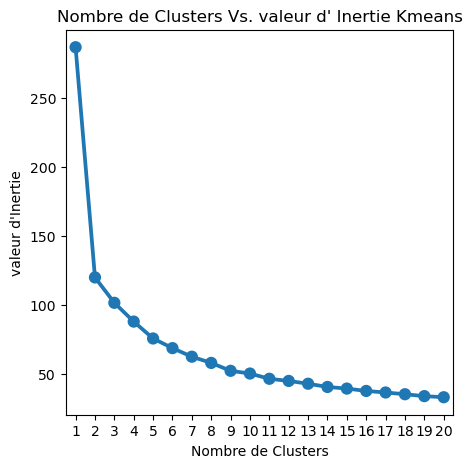

In [47]:
import seaborn as sns

sns.pointplot(x = clusters, y = inertia_values)
plt.xlabel('Nombre de Clusters')
plt.ylabel("valeur d'Inertie")
plt.title("Nombre de Clusters Vs. valeur d' Inertie Kmeans")
plt.draw()
plt.savefig("coude inertie.jpg",bbox="tight")

##Visualisation de la partition obtenue dans le premier plan factoriel de l'ACP.

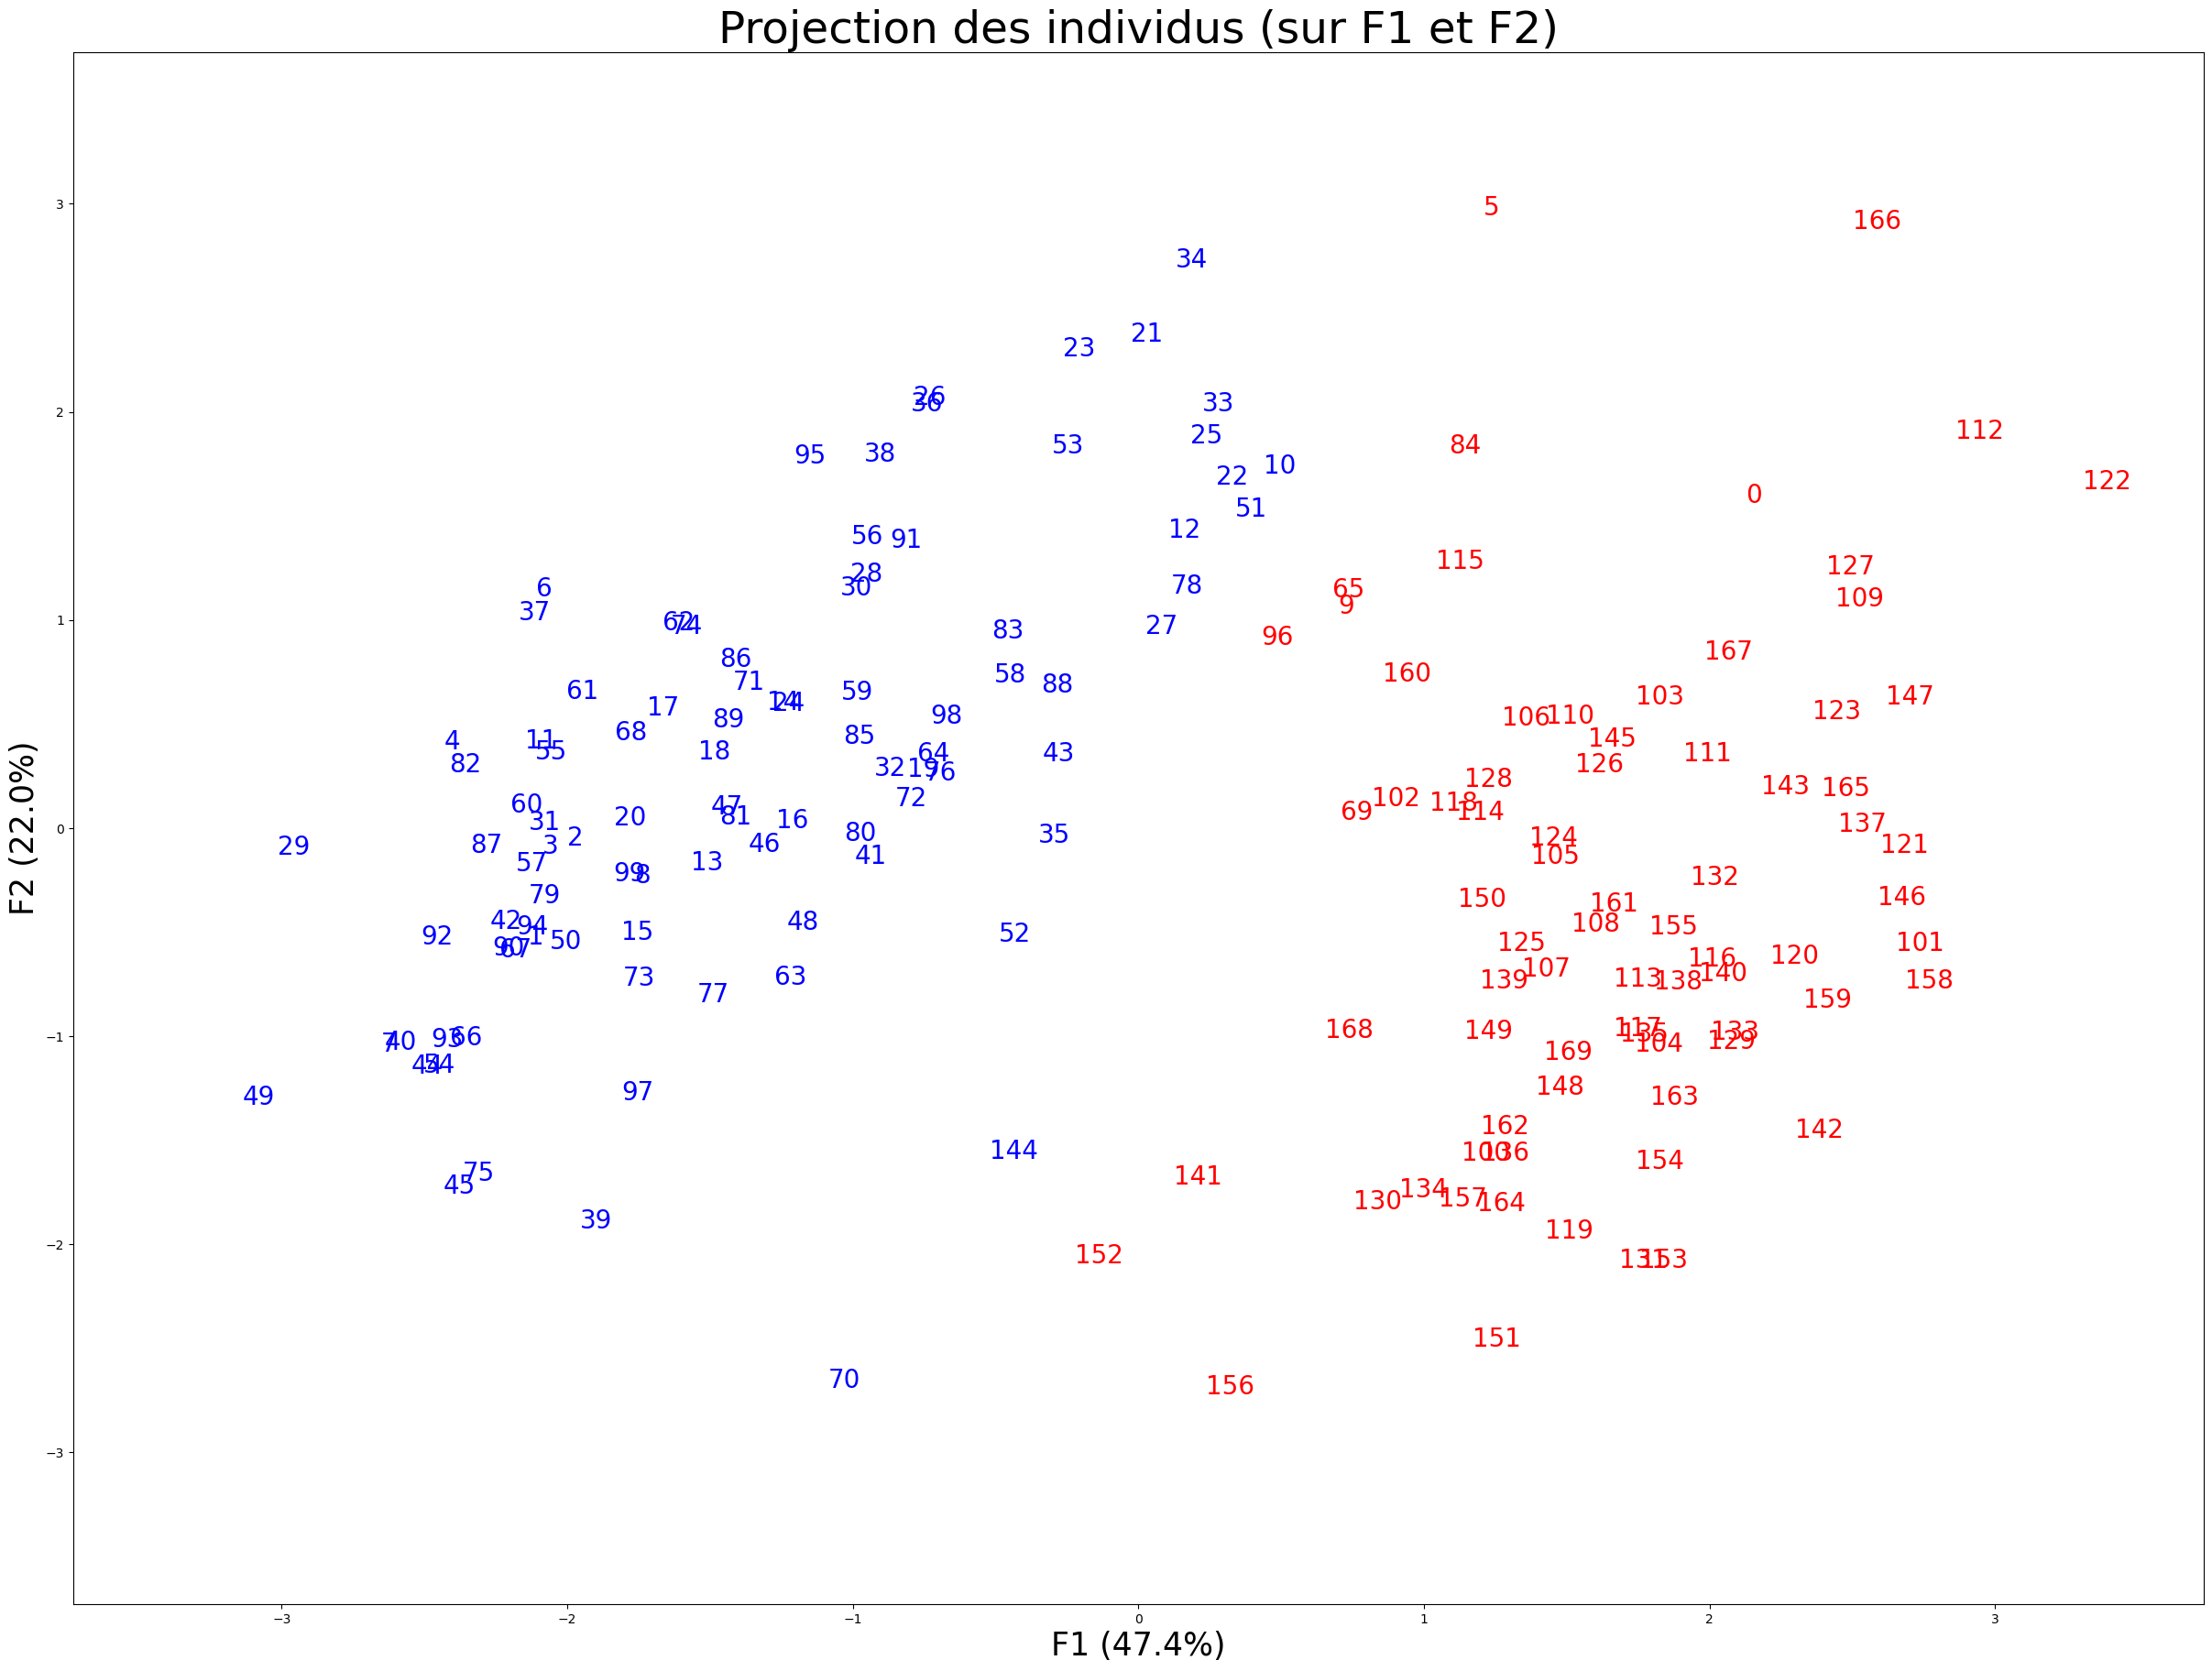

In [48]:
display_factorial_planes(X_projected, n_comp, pca, [(0,1)], labels = notes.index, clusters = y_kmeans)
plt.savefig("individus_KM.jpg",bbox="tight")

In [49]:
#Intégration des résultats de l'algorithme KMeans a F_data
df = pd.DataFrame(data=y_kmeans, columns=["y_kmeans"])
df.rename(columns={"y_kmeans":"KM_genuine"},inplace=True)
F_data = pd.concat([F_data, df], axis=1).copy()
del df
F_data

,F1,F2,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length,KM_genuine
0,2.153639,1.599709,1,171.81,104.86,104.95,4.52,2.89,112.83,0
1,-2.110416,-0.526039,1,171.67,103.74,103.70,4.01,2.87,113.29,1
2,-1.973152,-0.048102,1,171.83,103.76,103.76,4.40,2.88,113.84,1
3,-2.059795,-0.089105,1,171.80,103.78,103.65,3.73,3.12,113.63,1
4,-2.403180,0.412170,1,172.05,103.70,103.75,5.04,2.27,113.55,1
...,...,...,...,...,...,...,...,...,...,...
165,2.478626,0.189974,0,172.11,104.23,104.45,5.24,3.58,111.78,0
166,2.585331,2.914472,0,173.01,104.59,104.31,5.04,3.05,110.91,0
167,2.067245,0.845602,0,172.47,104.27,104.10,4.88,3.33,110.68,0
168,0.739257,-0.972965,0,171.82,103.97,103.88,4.73,3.55,111.87,0


In [50]:
#erreurs kmeans
F_data[F_data['is_genuine'] != F_data['KM_genuine']].iloc[:,3:9]

,diagonal,height_left,height_right,margin_low,margin_up,length
0,171.81,104.86,104.95,4.52,2.89,112.83
5,172.57,104.65,104.44,4.54,2.99,113.16
9,172.14,104.34,104.20,4.63,3.02,112.47
65,172.16,104.43,104.06,4.51,3.19,112.69
69,171.94,104.11,104.16,4.08,3.35,111.76
84,172.30,104.58,104.17,4.36,3.33,112.98
96,172.00,104.32,104.26,4.53,3.04,112.93
144,171.56,103.80,103.87,5.66,2.98,112.95


In [51]:
print("Pourcentage de similitude de KMeans comparé aux résultats rééels est de ",accuracy_score(F_data['KM_genuine'].values, F_data['is_genuine'].values)*100,'%')

Pourcentage de similitude de KMeans comparé aux résultats rééels est de  95.29411764705881 %


In [52]:
#matrice de confusion
print("la matrice de confusion kmeans")
print(confusion_matrix(F_data['is_genuine'],F_data['KM_genuine']))

la matrice de confusion kmeans
[[69  1]
 [ 7 93]]


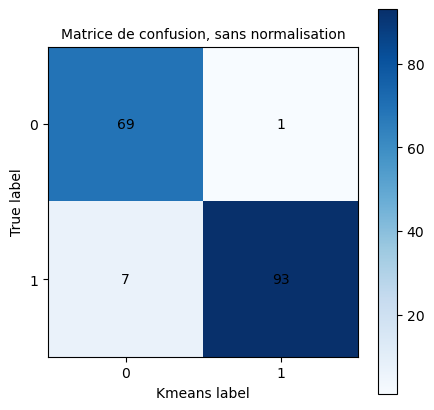

In [53]:
# Compute confusion matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(F_data['is_genuine'], F_data['KM_genuine'])

# Plot confusion matrix
plt.title("Matrice de confusion, sans normalisation", fontsize=10)
plt.imshow(cm,interpolation='none',cmap='Blues')
for (i, j), z in np.ndenumerate(cm):
    plt.text(j, i, z, ha='center', va='center')

#x_label_list = ['A2', 'B2', 'C2', 'D2']
#ax.set_xticks([-0.75,-0.25,0.25,0.75])
#plt.gca().yaxis.set_ticks(range(0, 1, 1), minor = True)
plt.xticks(np.arange(0,2,1), np.arange(0,2,1))
plt.yticks(np.arange(0,2,1), np.arange(0,2,1))
plt.xlabel("Kmeans label")
plt.ylabel("True label")
plt.colorbar()
plt.draw()
plt.savefig("matrix_km.jpg",bbox="tight")

In [54]:
#Réorganisation des colonnes de F_data
F_data = F_data[['diagonal', 'height_left', 'height_right','margin_low', 'margin_up', 'length','F1','F2', 'KM_genuine','is_genuine']]
F_data

,diagonal,height_left,height_right,margin_low,margin_up,length,F1,F2,KM_genuine,is_genuine
0,171.81,104.86,104.95,4.52,2.89,112.83,2.153639,1.599709,0,1
1,171.67,103.74,103.70,4.01,2.87,113.29,-2.110416,-0.526039,1,1
2,171.83,103.76,103.76,4.40,2.88,113.84,-1.973152,-0.048102,1,1
3,171.80,103.78,103.65,3.73,3.12,113.63,-2.059795,-0.089105,1,1
4,172.05,103.70,103.75,5.04,2.27,113.55,-2.403180,0.412170,1,1
...,...,...,...,...,...,...,...,...,...,...
165,172.11,104.23,104.45,5.24,3.58,111.78,2.478626,0.189974,0,0
166,173.01,104.59,104.31,5.04,3.05,110.91,2.585331,2.914472,0,0
167,172.47,104.27,104.10,4.88,3.33,110.68,2.067245,0.845602,0,0
168,171.82,103.97,103.88,4.73,3.55,111.87,0.739257,-0.972965,0,0


##Modélisation des données à l'aide d'une régression logistique

In [55]:
#preparation des donnees de test et d entrainement
X=F_data.iloc[:,0:6].values
y=F_data.iloc[:,-1].values
#X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=42)

In [56]:
#creation du model
model=LogisticRegression()

In [57]:
#entrainement du modele
#model.fit(X_train,y_train)
model.fit(X,y)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [58]:
testos = pd.DataFrame({"faux_%": model.predict_proba(X)[:,0]* 100, "vrai_%": model.predict_proba(X)[:,1]* 100})

In [59]:
def probav(dataset):
    print("Ajout de la colonne proba, 1 pour vrai billet, 0 pour faux billet")
    def billet(x):
        if x >= 50:
            return 1
        
        else:
            return 0
        

    dataset['prediction'] = dataset['vrai_%'].apply(lambda x: billet(x))
    return dataset

In [60]:
probav(testos)

Ajout de la colonne proba, 1 pour vrai billet, 0 pour faux billet


,faux_%,vrai_%,prediction
0,36.289278,63.710722,1
1,0.623324,99.376676,1
2,0.640269,99.359731,1
3,0.197000,99.803000,1
4,3.026446,96.973554,1
...,...,...,...
165,98.351350,1.648650,0
166,99.369354,0.630646,0
167,99.287611,0.712389,0
168,82.391292,17.608708,0


In [61]:
#Intégration des résultats de la prédiction de la régression logistique à F_data
F_data = pd.concat([F_data, testos.iloc[:,1:3]], axis=1).copy()
F_data['vrai_%'] = round(F_data['vrai_%'],2).copy()
F_data

,diagonal,height_left,height_right,margin_low,margin_up,length,F1,F2,KM_genuine,is_genuine,vrai_%,prediction
0,171.81,104.86,104.95,4.52,2.89,112.83,2.153639,1.599709,0,1,63.71,1
1,171.67,103.74,103.70,4.01,2.87,113.29,-2.110416,-0.526039,1,1,99.38,1
2,171.83,103.76,103.76,4.40,2.88,113.84,-1.973152,-0.048102,1,1,99.36,1
3,171.80,103.78,103.65,3.73,3.12,113.63,-2.059795,-0.089105,1,1,99.80,1
4,172.05,103.70,103.75,5.04,2.27,113.55,-2.403180,0.412170,1,1,96.97,1
...,...,...,...,...,...,...,...,...,...,...,...,...
165,172.11,104.23,104.45,5.24,3.58,111.78,2.478626,0.189974,0,0,1.65,0
166,173.01,104.59,104.31,5.04,3.05,110.91,2.585331,2.914472,0,0,0.63,0
167,172.47,104.27,104.10,4.88,3.33,110.68,2.067245,0.845602,0,0,0.71,0
168,171.82,103.97,103.88,4.73,3.55,111.87,0.739257,-0.972965,0,0,17.61,0


##Visualisation de la partition obtenue dans le premier plan factoriel de l'ACP

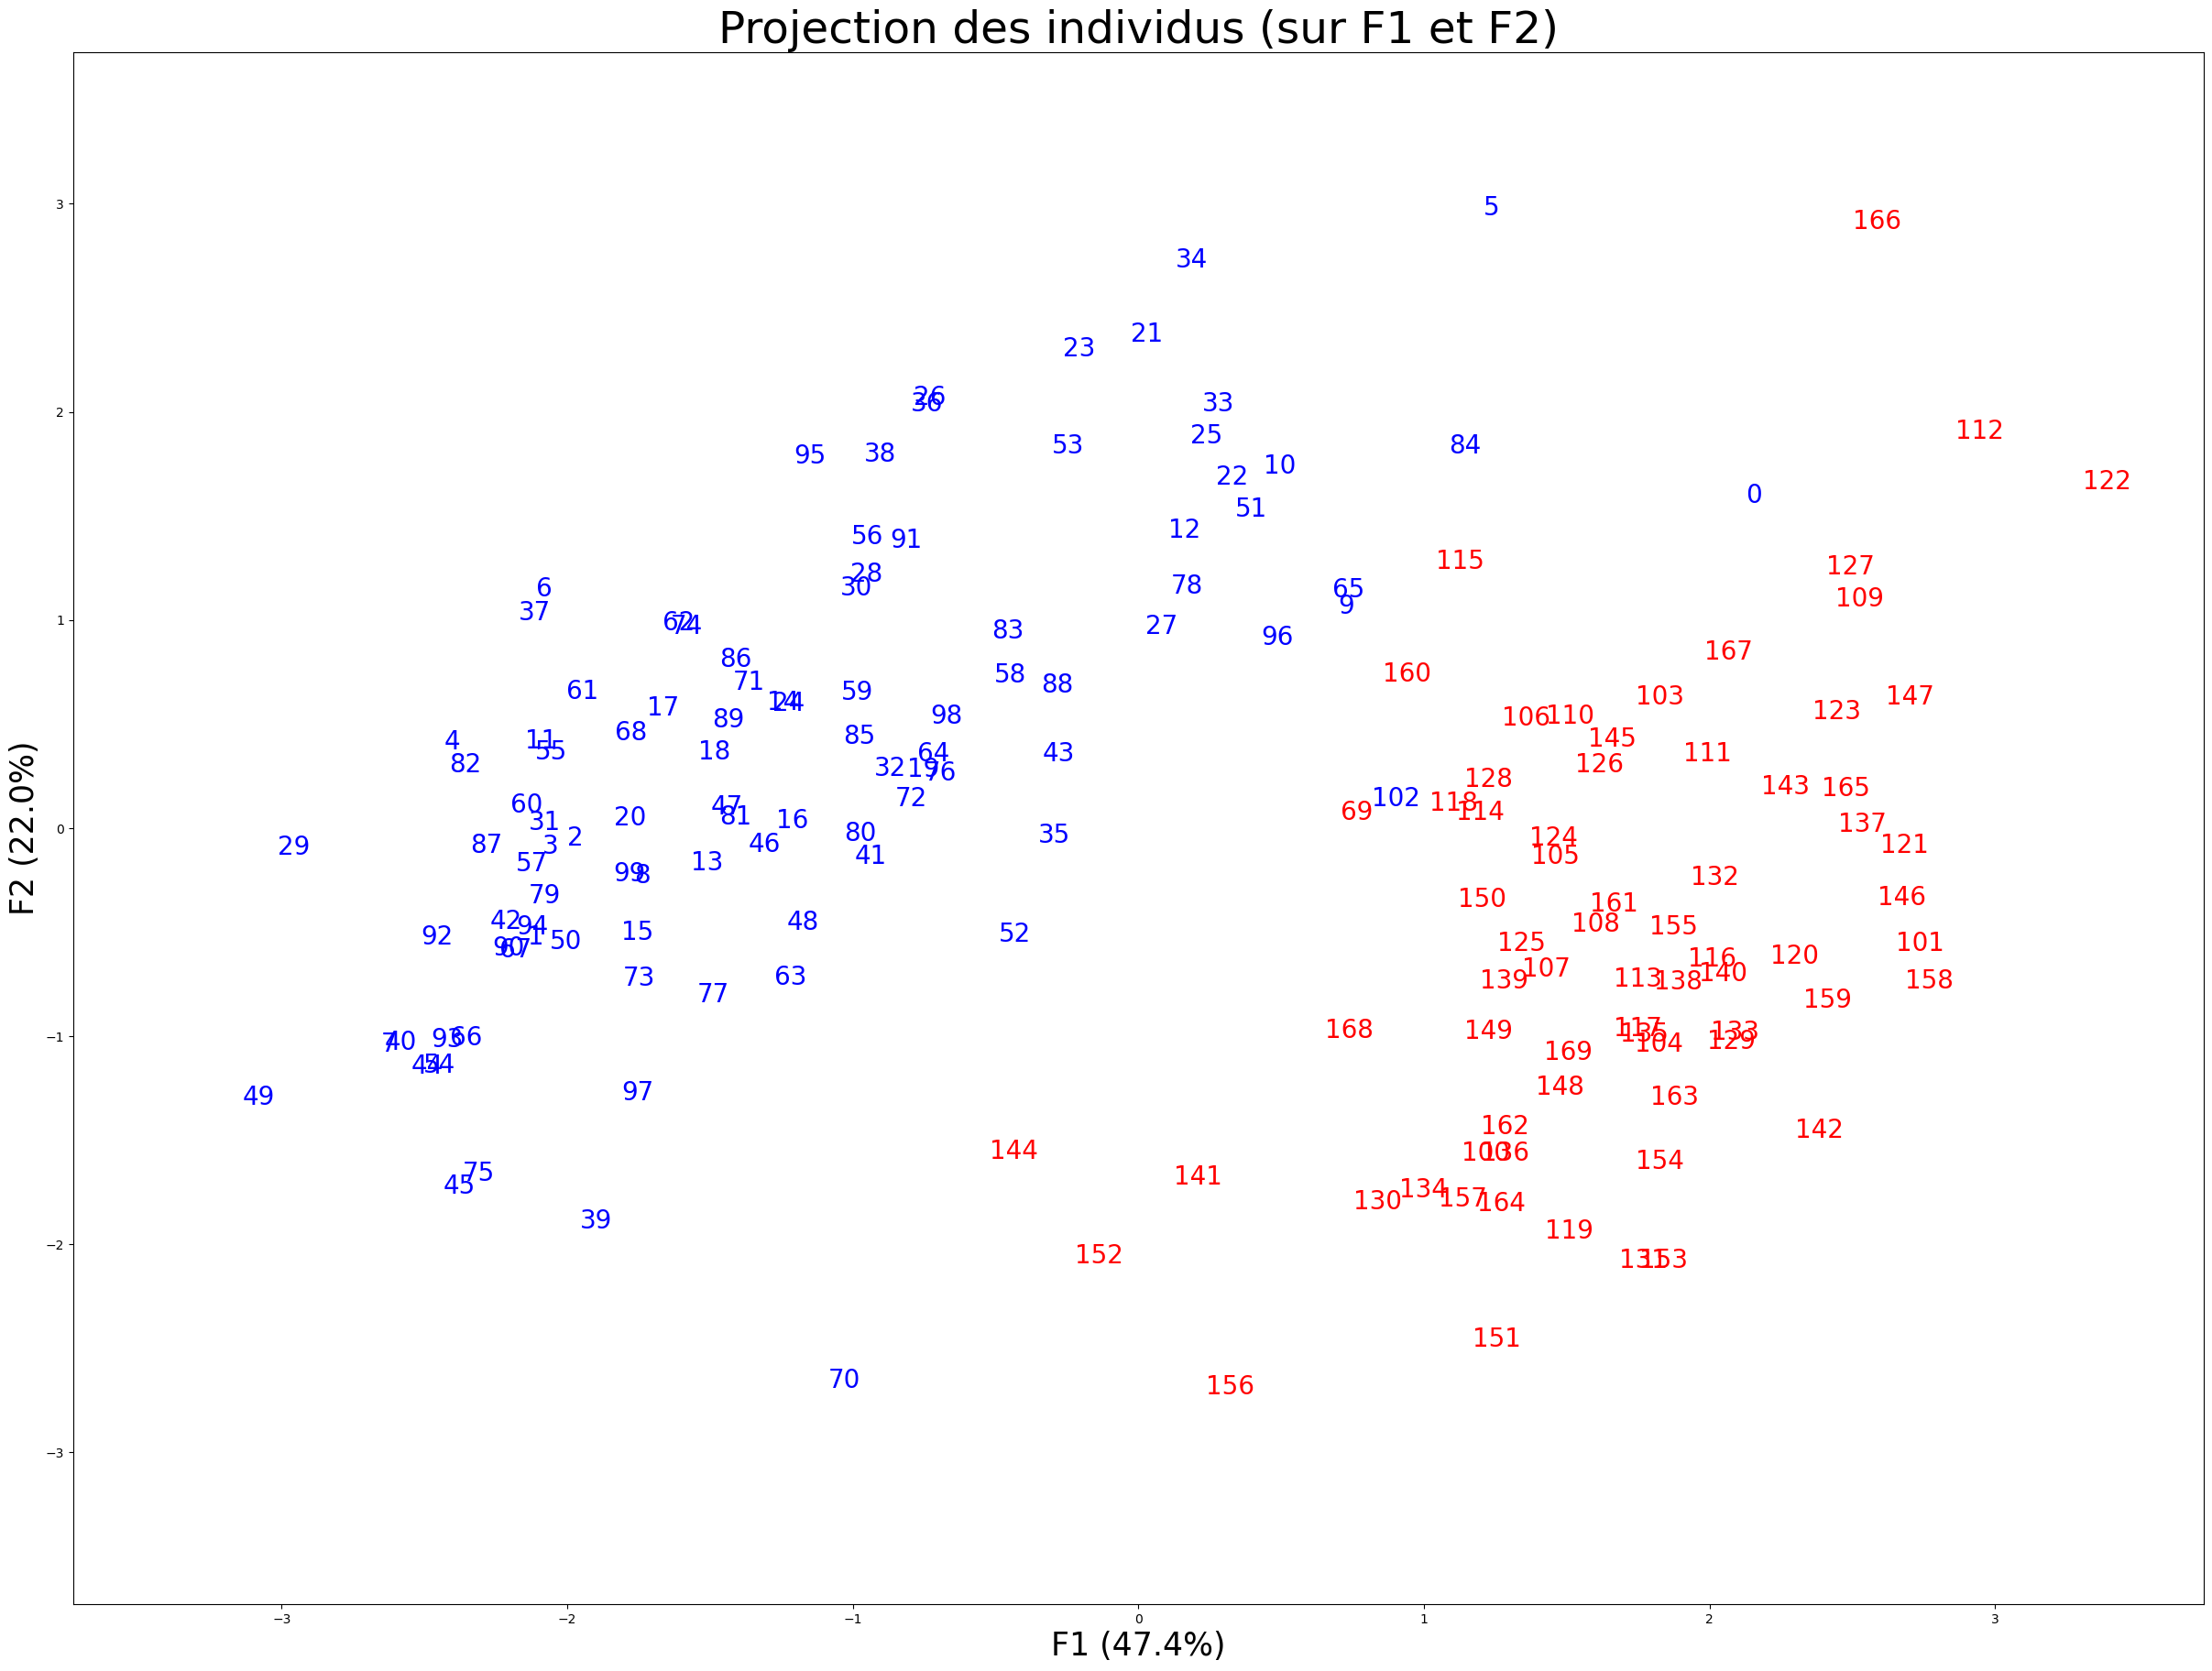

In [62]:
display_factorial_planes(X_projected, n_comp, pca, [(0,1)], labels = F_data.index, clusters = F_data.prediction)
plt.savefig("individus_al.jpg",bbox="tight")

In [63]:
#erreurs de la prédiction de la régression logistique
F_data[F_data['is_genuine'] != F_data['prediction']]

,diagonal,height_left,height_right,margin_low,margin_up,length,F1,F2,KM_genuine,is_genuine,vrai_%,prediction
69,171.94,104.11,104.16,4.08,3.35,111.76,0.765438,0.073366,0,1,48.47,0
102,171.94,104.21,104.10,4.28,3.47,112.23,0.901311,0.141600,0,0,56.07,1


In [64]:
print("Pourcentage de similitude apres test de l'algorithme sur les données d'entrainement : ",round(((F_data['prediction'] == F_data['is_genuine']).sum()/len(F_data))*100,2),'%')

Pourcentage de similitude apres test de l'algorithme sur les données d'entrainement :  98.82 %


In [65]:
#matrice de confusion de l 'algorithme'
print("la matrice de confusion")
print(confusion_matrix(F_data['is_genuine'],F_data['prediction']))

la matrice de confusion
[[69  1]
 [ 1 99]]


Automatically created module for IPython interactive environment
Matrice de confusion, sans normalisation
[[69  1]
 [ 1 99]]


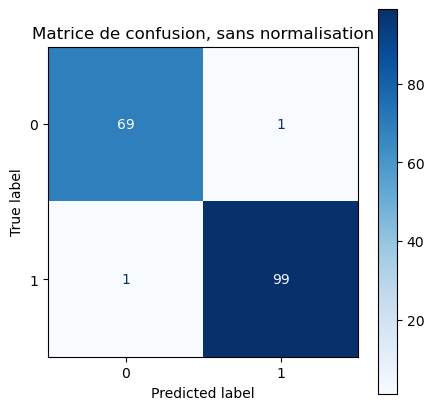

In [66]:
print(__doc__)

import numpy as np
import matplotlib.pyplot as plt

from sklearn import svm, datasets
#from sklearn.model_selection import train_test_split
from sklearn.metrics import plot_confusion_matrix

# import some data to play with
#iris = datasets.load_iris()
#X = iris.data
#y = iris.target
class_names = names

# Split the data into a training set and a test set
#X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

# Run classifier, using a model that is too regularized (C too low) to see
# the impact on the results
classifier = model.fit(X,y)

np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
titles_options = [("Matrice de confusion, sans normalisation", None)]
for title, normalize in titles_options:
    disp = plot_confusion_matrix(classifier, X, y,
                                 display_labels=class_names,
                                 cmap=plt.cm.Blues,
                                 normalize=normalize)
    disp.ax_.set_title(title)

    print(title)
    print(disp.confusion_matrix)

plt.draw()
plt.savefig("matrix.jpg",bbox="tight")

In [67]:
F_data.loc[(F_data["prediction"]!=F_data['KM_genuine']),['is_genuine','KM_genuine','prediction']]

,is_genuine,KM_genuine,prediction
0,1,0,1
5,1,0,1
9,1,0,1
65,1,0,1
84,1,0,1
96,1,0,1
102,0,0,1
144,0,1,0


In [68]:
import pandas as pd
def billet(x):
    if x >= 50:
        return 1
    else:
        return 0
    
test = input("Nom du fichier à traiter (sans l'extension .csv) : ")
dataset = pd.read_csv(test+'.csv')
data = dataset[['diagonal', 'height_left', 'height_right', 'margin_low', 'margin_up','length']].copy()
print("Ajout de la colonne prediction, 1 pour un vrai billet, 0 pour un faux billet")
print("Résultats de la verification de vos billets: ")
dataset['vrai_%'] = model.predict_proba(data)[:,1]* 100
dataset['prediction'] = dataset['vrai_%'].apply(lambda x: billet(x))
dataset['vrai_%'] = round(dataset['vrai_%'],2)
del data
print(round((dataset[dataset['prediction'] == 1].shape[0])/(dataset.shape[0]),2)*100, "pourcents des billets sont vrais.")
dataset

Nom du fichier à traiter (sans l'extension .csv) : example
Ajout de la colonne prediction, 1 pour un vrai billet, 0 pour un faux billet
Résultats de la verification de vos billets: 
40.0 pourcents des billets sont vrais.


,diagonal,height_left,height_right,margin_low,margin_up,length,id,vrai_%,prediction
0,171.76,104.01,103.54,5.21,3.30,111.42,A_1,4.00,0
1,171.87,104.17,104.13,6.00,3.31,112.09,A_2,0.91,0
2,172.00,104.58,104.29,4.99,3.39,111.57,A_3,2.77,0
3,172.49,104.55,104.34,4.44,3.03,113.20,A_4,87.74,1
4,171.65,103.63,103.56,3.77,3.16,113.33,A_5,99.64,1


In [69]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score,confusion_matrix



def billet(x):
    if x >= 50:
        return 1
    else:
        return 0
    
entr = input("Nom du fichier d'entrainement (sans l'extension .csv) : ")
data2 = pd.read_csv(entr+'.csv')
data2['is_genuine'] = data2['is_genuine'].replace({False:0 ,True:1})
X=data2[['diagonal', 'height_left', 'height_right', 'margin_low', 'margin_up','length']].values
y=data2['is_genuine'].values#vecteur , pas un dataframe
#creation du model
model=LogisticRegression()
#entrainement du modele
model.fit(X,y)
#print("Pourcentage d'efficacité : ",data2['is_genuine'] == model.predict_proba(X)[:,1].apply(lambda x: billet(x)).sum()/(data2.shape[0]))
pourc = data2[data2['is_genuine'] == (model.predict_proba(X)[:,1] >= 0.5)].count()['is_genuine']/(data2.shape[0])*100
print("Pourcentage de précision après test de l'algorithme sur les données d'entrainement : ",round(pourc,2),"%.")

    
test = input("Nom du fichier à traiter (sans l'extension .csv) : ")
dataset = pd.read_csv(test+'.csv')
data = dataset[['diagonal', 'height_left', 'height_right', 'margin_low', 'margin_up','length']].copy()
print("Ajout de la colonne 'prediction', 1 pour un vrai billet, 0 pour un faux billet.")
print("Résultats de la verification de vos billets: ")
dataset['vrai_%'] = model.predict_proba(data)[:,1]* 100
dataset['prediction'] = dataset['vrai_%'].apply(lambda x: billet(x))
dataset['vrai_%'] = round(dataset['vrai_%'],2)
del data
print(round((dataset[dataset['prediction'] == 1].shape[0])/(dataset.shape[0]),2)*100, "pourcents des billets sont vrais.")
dataset

Nom du fichier d'entrainement (sans l'extension .csv) : notes
Pourcentage de précision après test de l'algorithme sur les données d'entrainement :  98.82 %.
Nom du fichier à traiter (sans l'extension .csv) : example
Ajout de la colonne 'prediction', 1 pour un vrai billet, 0 pour un faux billet.
Résultats de la verification de vos billets: 
40.0 pourcents des billets sont vrais.


,diagonal,height_left,height_right,margin_low,margin_up,length,id,vrai_%,prediction
0,171.76,104.01,103.54,5.21,3.30,111.42,A_1,4.00,0
1,171.87,104.17,104.13,6.00,3.31,112.09,A_2,0.91,0
2,172.00,104.58,104.29,4.99,3.39,111.57,A_3,2.77,0
3,172.49,104.55,104.34,4.44,3.03,113.20,A_4,87.74,1
4,171.65,103.63,103.56,3.77,3.16,113.33,A_5,99.64,1


In [354]:
#test
example = pd.read_csv("example.csv")#example
print(example.shape)
example.head(5)

(5, 7)


,diagonal,height_left,height_right,margin_low,margin_up,length,id
0,171.76,104.01,103.54,5.21,3.30,111.42,A_1
1,171.87,104.17,104.13,6.00,3.31,112.09,A_2
2,172.00,104.58,104.29,4.99,3.39,111.57,A_3
3,172.49,104.55,104.34,4.44,3.03,113.20,A_4
4,171.65,103.63,103.56,3.77,3.16,113.33,A_5


In [62]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score,confusion_matrix
from sklearn import metrics
from sklearn import svm



def billet(x):
    if x >= 50:
        return 1
    else:
        return 0
    
entr = input("Nom du fichier d'entrainement (sans l'extension .csv) : ")
data2 = pd.read_csv(entr+'.csv')
data2['is_genuine'] = data2['is_genuine'].replace({False:0 ,True:1})
X=data2[['diagonal', 'height_left', 'height_right', 'margin_low', 'margin_up','length']].values
y=data2['is_genuine'].values#vecteur , pas un dataframe
#creation du model
model=svm.SVC(kernel='linear')
#entrainement du modele
model.fit(X,y)
#print("Pourcentage d'efficacité : ",data2['is_genuine'] == model.predict_proba(X)[:,1].apply(lambda x: billet(x)).sum()/(data2.shape[0]))
pourc = data2[data2['is_genuine'] == model.predict(X)].count()['is_genuine']/(data2.shape[0])*100
print("Pourcentage de similitude après test de l'algorithme sur les données d'entrainement : ",round(pourc,2),"%.")
print(metrics.confusion_matrix(y,model.predict(X)))

    
test = input("Nom du fichier à traiter (sans l'extension .csv) : ")
dataset = pd.read_csv(test+'.csv')
data = dataset[['diagonal', 'height_left', 'height_right', 'margin_low', 'margin_up','length']].copy()
print("Ajout de la colonne 'prediction', 1 pour un vrai billet, 0 pour un faux billet.")
print("Résultats de la verification de vos billets: ")

dataset['prediction'] = model.predict(data)

del data
print(round((dataset[dataset['prediction'] == 1].shape[0])/(dataset.shape[0]),2)*100, "pourcents des billets sont vrais.")
#print(metrics.accuracy_score(y,model.predict(X)))
dataset

Nom du fichier d'entrainement (sans l'extension .csv) : notes
Pourcentage de similitude après test de l'algorithme sur les données d'entrainement :  99.41 %.
[[70  0]
 [ 1 99]]
Nom du fichier à traiter (sans l'extension .csv) : example
Ajout de la colonne 'prediction', 1 pour un vrai billet, 0 pour un faux billet.
Résultats de la verification de vos billets: 
40.0 pourcents des billets sont vrais.


,diagonal,height_left,height_right,margin_low,margin_up,length,id,prediction
0,171.76,104.01,103.54,5.21,3.30,111.42,A_1,0
1,171.87,104.17,104.13,6.00,3.31,112.09,A_2,0
2,172.00,104.58,104.29,4.99,3.39,111.57,A_3,0
3,172.49,104.55,104.34,4.44,3.03,113.20,A_4,1
4,171.65,103.63,103.56,3.77,3.16,113.33,A_5,1


In [63]:
#F_data[F_data['is_genuine'] != (model.predict_proba(X)[:,1] >= 0.5)]
data2[data2['is_genuine'] != (model.predict(X))]

,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length
69,1,171.94,104.11,104.16,4.08,3.35,111.76


In [64]:
print(metrics.confusion_matrix(y,model.predict(X)))

[[70  0]
 [ 1 99]]


In [87]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score,confusion_matrix
from sklearn import metrics
from sklearn import svm



def billet(x):
    if x >= 50:
        return 1
    else:
        return 0
    
entr = input("Nom du fichier d'entrainement (sans l'extension .csv) : ")
data2 = pd.read_csv(entr+'.csv')
data2['is_genuine'] = data2['is_genuine'].replace({False:0 ,True:1})
X=data2[['diagonal', 'height_left', 'height_right', 'margin_low', 'margin_up','length']].values
y=data2['is_genuine'].values#vecteur , pas un dataframe
#creation du model
model=KNeighborsClassifier(n_neighbors=5)
#entrainement du modele
model.fit(X,y)
#print("Pourcentage d'efficacité : ",data2['is_genuine'] == model.predict_proba(X)[:,1].apply(lambda x: billet(x)).sum()/(data2.shape[0]))
pourc = data2[data2['is_genuine'] == model.predict(X)].count()['is_genuine']/(data2.shape[0])*100
print("Pourcentage de similitude après test de l'algorithme sur les données d'entrainement : ",round(pourc,2),"%.")
print(metrics.confusion_matrix(y,model.predict(X)))

    
test = input("Nom du fichier à traiter (sans l'extension .csv) : ")
dataset = pd.read_csv(test+'.csv')
data = dataset[['diagonal', 'height_left', 'height_right', 'margin_low', 'margin_up','length']].copy()
print("Ajout de la colonne 'prediction', 1 pour un vrai billet, 0 pour un faux billet.")
print("Résultats de la verification de vos billets: ")

dataset['prediction'] = model.predict(data)

#del data
print(round((dataset[dataset['prediction'] == 1].shape[0])/(dataset.shape[0]),2)*100, "pourcents des billets sont vrais.")
#print(metrics.accuracy_score(y,model.predict(X)))
dataset

Nom du fichier d'entrainement (sans l'extension .csv) : notes
Pourcentage de similitude après test de l'algorithme sur les données d'entrainement :  99.41 %.
[[70  0]
 [ 1 99]]
Nom du fichier à traiter (sans l'extension .csv) : example
Ajout de la colonne 'prediction', 1 pour un vrai billet, 0 pour un faux billet.
Résultats de la verification de vos billets: 
40.0 pourcents des billets sont vrais.


,diagonal,height_left,height_right,margin_low,margin_up,length,id,prediction
0,171.76,104.01,103.54,5.21,3.30,111.42,A_1,0
1,171.87,104.17,104.13,6.00,3.31,112.09,A_2,0
2,172.00,104.58,104.29,4.99,3.39,111.57,A_3,0
3,172.49,104.55,104.34,4.44,3.03,113.20,A_4,1
4,171.65,103.63,103.56,3.77,3.16,113.33,A_5,1


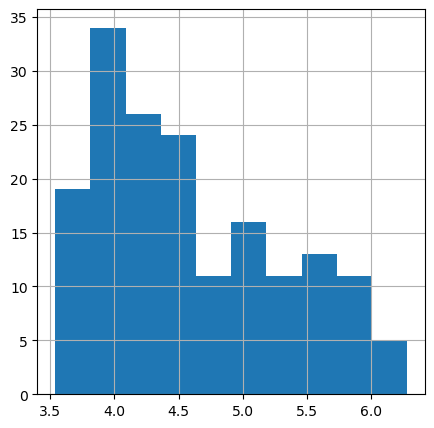

In [90]:
data2['margin_low'].hist()

In [ ]:
data2[data2['is_genuine']

In [89]:
data2[data2['is_genuine'] != (model.predict(X))]

,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length
69,1,171.94,104.11,104.16,4.08,3.35,111.76


In [69]:
ciit.iloc[69,:]

contrib_it    2.446859
Name: 69, dtype: float64

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001684BF19108>]],
      dtype=object)

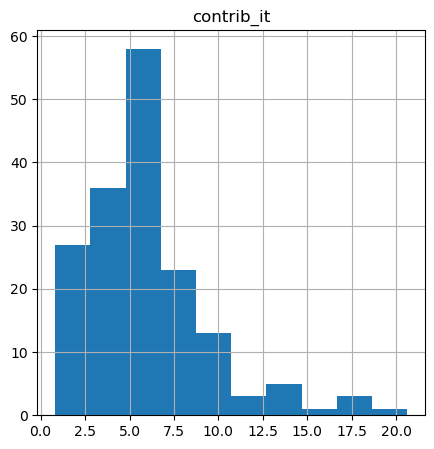

In [71]:
ciit.hist()

In [74]:
#testo.sort_values(by='COS2_F1F2')
testo.iloc[69,:]

COS2_1          0.239448
COS2_2        0.00219979
COS2_F1F2       0.241648
is_genuine          True
Name: 69, dtype: object

In [77]:
testo.sort_values(by='is_genuine')

,COS2_1,COS2_2,COS2_F1F2,is_genuine
169,0.421817,0.217111,0.638928,False
131,0.363368,0.501595,0.864963,False
130,0.148647,0.681582,0.830229,False
129,0.496233,0.120991,0.617224,False
128,0.712138,0.025492,0.737630,False
...,...,...,...,...
58,0.111922,0.299712,0.411635,True
59,0.651764,0.287865,0.939629,True
60,0.805623,0.002125,0.807748,True
52,0.076673,0.106134,0.182807,True


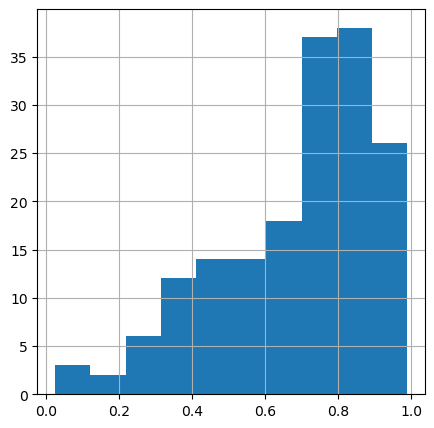

In [83]:
testo['COS2_F1F2'].hist()

In [33]:
#???????????????????????????????????????????????????????
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score,confusion_matrix
from sklearn import metrics
from sklearn import svm



def billet(x):
    if x >= 50:
        return 1
    else:
        return 0
    
entr = input("Nom du fichier d'entrainement (sans l'extension .csv) : ")
data2 = pd.read_csv(entr+'.csv')
data2['is_genuine'] = data2['is_genuine'].replace({False:0 ,True:1})
X=data2[['diagonal', 'height_left', 'height_right', 'margin_low', 'margin_up','length']].values
y=data2['is_genuine'].values#vecteur , pas un dataframe
#creation du model
model=svm.SVC(kernel='sigmoid',degree=200,C=0.2)
#entrainement du modele
model.fit(X,y)
#print("Pourcentage d'efficacité : ",data2['is_genuine'] == model.predict_proba(X)[:,1].apply(lambda x: billet(x)).sum()/(data2.shape[0]))
pourc = data2[data2['is_genuine'] == model.predict(X)].count()['is_genuine']/(data2.shape[0])*100
print("Pourcentage de similitude après test de l'algorithme sur les données d'entrainement : ",round(pourc,2),"%.")
print(metrics.confusion_matrix(y,model.predict(X)))

    
test = input("Nom du fichier à traiter (sans l'extension .csv) : ")
dataset = pd.read_csv(test+'.csv')
data = dataset[['diagonal', 'height_left', 'height_right', 'margin_low', 'margin_up','length']].copy()
print("Ajout de la colonne 'prediction', 1 pour un vrai billet, 0 pour un faux billet.")
print("Résultats de la verification de vos billets: ")

dataset['prediction'] = model.predict(data)

del data
print(round((dataset[dataset['prediction'] == 1].shape[0])/(dataset.shape[0]),2)*100, "pourcents des billets sont vrais.")
#print(metrics.accuracy_score(y,model.predict(X)))
dataset

Nom du fichier d'entrainement (sans l'extension .csv) : notes
Pourcentage de similitude après test de l'algorithme sur les données d'entrainement :  58.82 %.
[[  0  70]
 [  0 100]]
Nom du fichier à traiter (sans l'extension .csv) : example
Ajout de la colonne 'prediction', 1 pour un vrai billet, 0 pour un faux billet.
Résultats de la verification de vos billets: 
100.0 pourcents des billets sont vrais.


,diagonal,height_left,height_right,margin_low,margin_up,length,id,prediction
0,171.76,104.01,103.54,5.21,3.30,111.42,A_1,1
1,171.87,104.17,104.13,6.00,3.31,112.09,A_2,1
2,172.00,104.58,104.29,4.99,3.39,111.57,A_3,1
3,172.49,104.55,104.34,4.44,3.03,113.20,A_4,1
4,171.65,103.63,103.56,3.77,3.16,113.33,A_5,1


In [173]:
F_data.groupby('is_genuine').size()

is_genuine
0     70
1    100
dtype: int64

In [178]:
(F_data['is_genuine'] == F_data['prediction']).sum()/len(F_data)

0.9882352941176471

In [183]:
data2[data2['is_genuine'] != (model.predict_proba(X)[:,1] >= 0.5)]

,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length
69,1,171.94,104.11,104.16,4.08,3.35,111.76
102,0,171.94,104.21,104.10,4.28,3.47,112.23


In [184]:
#erreurs algo
F_data[F_data['is_genuine'] != F_data['prediction']]

,diagonal,height_left,height_right,margin_low,margin_up,length,F1,F2,KM_genuine,is_genuine,vrai_%,prediction
69,171.94,104.11,104.16,4.08,3.35,111.76,0.765438,0.073366,0,1,48.47,0
102,171.94,104.21,104.10,4.28,3.47,112.23,0.901311,0.141600,0,0,56.07,1


In [185]:
#erreurs kmeans
F_data[F_data['is_genuine'] != F_data['KM_genuine']]

,diagonal,height_left,height_right,margin_low,margin_up,length,F1,F2,KM_genuine,is_genuine,vrai_%,prediction
0,171.81,104.86,104.95,4.52,2.89,112.83,2.153639,1.599709,0,1,63.71,1
5,172.57,104.65,104.44,4.54,2.99,113.16,1.235656,2.983191,0,1,81.21,1
9,172.14,104.34,104.20,4.63,3.02,112.47,0.727490,1.063881,0,1,55.30,1
10,172.27,104.29,104.22,3.89,3.53,113.50,0.495826,1.738478,0,1,97.81,1
65,172.16,104.43,104.06,4.51,3.19,112.69,0.736937,1.146021,0,1,70.55,1
69,171.94,104.11,104.16,4.08,3.35,111.76,0.765438,0.073366,0,1,48.47,0
84,172.30,104.58,104.17,4.36,3.33,112.98,1.145082,1.837529,0,1,81.48,1
96,172.00,104.32,104.26,4.53,3.04,112.93,0.487370,0.916649,0,1,81.66,1
144,171.56,103.80,103.87,5.66,2.98,112.95,-0.435376,-1.554947,1,0,33.10,0


In [186]:
ciit.iloc[69,:],ciit.iloc[102,:]

(contrib_it    2.446859
 Name: 69, dtype: float64,
 contrib_it    2.482276
 Name: 102, dtype: float64)

In [187]:
ciit.sum()

contrib_it    1020.0
dtype: float64

In [189]:
ciit.sort_values(by='contrib_it').head(30)

,contrib_it
ID,
64,0.813929
98,0.878319
85,1.431664
76,1.435202
59,1.484454
83,1.659976
32,1.716885
46,1.777577
58,1.809956


In [190]:
testo.sort_values(by='COS2_F1F2').head(15)

,COS2_1,COS2_2,COS2_F1F2,is_genuine
35,0.024786,0.000346,0.025132,True
43,0.038755,0.063289,0.102043,True
160,0.068742,0.042901,0.111643,False
88,0.023273,0.135767,0.159040,True
52,0.076673,0.106134,0.182807,True
72,0.216591,0.006655,0.223246,True
118,0.229407,0.002600,0.232007,False
27,0.001655,0.234759,0.236414,True
69,0.239448,0.002200,0.241648,True
19,0.237964,0.033434,0.271399,True


In [348]:
dataset = toto[toto.columns[~toto.columns.isin(['is_genuine'])]].copy
def ana(toto):
    for column in dataset:
        print ("taille de l'echantillon", np.size(dataset[column]))
        print("la moyenne de la colonne ",column, dataset[column].mean())
        print("Médiane:\n",dataset[column].median())
        print("Mode:\n",dataset[column].mode())
        print("l'ecart type de la colonne ",column, dataset[column].std(ddof=1))
        print("la variance de la colonne ",column, dataset[column].var(ddof=1))
        print("skewness empirique:\n",dataset[column].skew())
        print("kurtosis empirique:\n",dataset[column].kurtosis())
        dataset[column].hist() # Crée l'histogramme
        plt.draw()

AttributeError: 'Series' object has no attribute 'columns'

In [50]:
test2 = pd.DataFrame({"test2": model.predict(X)})
test2

,test2
0,1
1,1
2,1
3,1
4,1
...,...
165,0
166,0
167,0
168,0


In [51]:
(F_data['is_genuine'] == test2['test2']).sum()/len(F_data)

0.9882352941176471

In [52]:
toto = pd.read_csv('example.csv')

In [53]:
def verif(dataset):
    data = dataset[['diagonal', 'height_left', 'height_right', 'margin_low', 'margin_up','length']].copy()
    print("si c'est un faux j'appel la police")
    dataset['vrai_%'] = model.predict_proba(data)[:,1]* 100
    def billet(x):
        if x >= 50:
            return 1
        
        else:
            return 0
        

    dataset['prediction'] = dataset['vrai_%'].apply(lambda x: billet(x))
    dataset['vrai_%'] = round(dataset['vrai_%'],2)
    print("Ajout de la colonne proba, 1 pour vrai billet, 0 pour faux billet")
    del data
    return dataset


In [54]:
verif(toto)

si c'est un faux j'appel la police
Ajout de la colonne proba, 1 pour vrai billet, 0 pour faux billet


,diagonal,height_left,height_right,margin_low,margin_up,length,id,vrai_%,prediction
0,171.76,104.01,103.54,5.21,3.30,111.42,A_1,4.00,0
1,171.87,104.17,104.13,6.00,3.31,112.09,A_2,0.91,0
2,172.00,104.58,104.29,4.99,3.39,111.57,A_3,2.77,0
3,172.49,104.55,104.34,4.44,3.03,113.20,A_4,87.74,1
4,171.65,103.63,103.56,3.77,3.16,113.33,A_5,99.64,1


In [57]:
def verif(test):
    dataset = pd.read_csv(test+'.csv')
    data = dataset[['diagonal', 'height_left', 'height_right', 'margin_low', 'margin_up','length']].copy()
    print("Résultats de la verification de vos billets: ")
    dataset['vrai_%'] = model.predict_proba(data)[:,1]* 100
    def billet(x):
        if x >= 50:
            return 1
        
        else:
            return 0
        

    dataset['prediction'] = dataset['vrai_%'].apply(lambda x: billet(x))
    dataset['vrai_%'] = round(dataset['vrai_%'],2)
    print("Ajout de la colonne prediction, 1 pour vrai billet, 0 pour faux billet")
    del data
    return dataset

In [59]:
X_scaled

array([[-0.42834385,  2.6694537 ,  3.09656321, -0.13159013, -1.18987367,
         0.28163308],
       [-0.88755932, -1.09769709, -0.69125444, -0.86012554, -1.27473985,
         0.78069736],
       [-0.36274164, -1.03042654, -0.50943919, -0.30301023, -1.23230676,
         1.37740465],
       ...,
       [ 1.73652911,  0.68497248,  0.52084721,  0.38267015,  0.67718214,
        -2.05094997],
       [-0.39554274, -0.32408577, -0.1458087 ,  0.16839504,  1.61071005,
        -0.75989238],
       [ 0.06367273, -0.22317994,  0.06630909,  1.45404575,  0.38015054,
        -1.74717171]])

In [60]:
X_projected

array([[ 2.15363875,  1.59970945,  1.78745079,  2.43346523,  0.69968952,
        -1.26770217],
       [-2.11041589, -0.52603892,  0.54256277,  0.34454951,  0.0674404 ,
        -0.54460079],
       [-1.97315242, -0.04810178,  0.85871563,  0.37481231, -0.4248861 ,
         0.08048667],
       ...,
       [ 2.06724502,  0.84560244, -0.61028227, -1.71417169,  0.1169579 ,
        -0.50433787],
       [ 0.73925685, -0.97296457, -1.35977212, -0.19173617, -0.24355701,
         0.21142914],
       [ 1.50499242, -1.07972486,  0.18888855, -1.34755225, -0.2891493 ,
        -0.06034599]])

In [65]:
di2 = np.sum((X_scaled)**2,axis=1)
di3 = np.sum((X_projected)**2,axis=1)
print(di2)
print(di3)

[18.41059773  5.44479913  4.96052735  4.80571914 18.03956654 11.52798451
  8.02902542  9.34433795  5.96163957  2.37365021  6.92508658  5.88603767
  5.57845059  3.5044568   2.77630174  9.07121651  4.15309085  5.38514092
  7.6671102   2.38556352  4.07607735  6.0203732   4.11416571  6.23396493
  3.62379624  6.15858354  5.94010181  3.98683368  3.19411016 10.11756139
  2.94088917  6.09251356  1.71688508  4.55893873  8.37458933  3.51841501
  4.97705146  5.95033666  5.93744942 15.05260763  9.97693432  1.8297429
  7.16773035  2.02462891  8.78316767  8.94982931  1.77757668  3.95123443
  2.19892131 12.91753759  4.79002473  4.23080101  2.45674953  4.35876105
  7.72427349  6.1239637   5.48012126  7.13679973  1.80995634  1.48445407
  5.69862224  5.85175785  5.10759065  3.07860308  0.81392884  2.21875606
  7.52176771  6.47897254  3.9393141   2.44685898 11.048897    2.74769093
  2.91932326  5.23262124  4.33314433  9.84711942  1.43520162  3.83595073
  3.60955938  4.926785    1.99015956  2.65565784  7.

In [94]:
#contribution des individus dans l'inertie totale
di = np.sum((X_scaled)**2,axis=1)
ciit = (pd.DataFrame({'ID':names,'d_i':di}))
ciit

,ID,d_i
0,0,18.410598
1,1,5.444799
2,2,4.960527
3,3,4.805719
4,4,18.039567
...,...,...
165,165,7.673233
166,166,20.625650
167,167,8.567410
168,168,3.482926


In [148]:
#qualité de représentation des individus - COS2
p=notes.iloc[:,1:7].shape[1]
cos2 = (X_projected)**2
for j in range(p):
 cos2[:,j] = cos2[:,j]/di
qri = pd.DataFrame({'id':names,'COS2_1':cos2[:,0],'COS2_2':cos2[:,1],'COS2_3':cos2[:,2],'COS2_4':cos2[:,3],'COS2_5':cos2[:,4],'COS2_6':cos2[:,5]})
qri['id'] = qri['id'].astype(str)
#qri.set_index('id', inplace=True)
qri['test22'] = qri.sum(axis=1)
qri.tail(50).sort_values(by='COS2_1')

,id,COS2_1,COS2_2,COS2_3,COS2_4,COS2_5,COS2_6
0,0,0.251929,0.139000,0.173540,0.321649,0.026592,0.087290
1,1,0.818002,0.050822,0.054065,0.021803,0.000835,0.054472
2,2,0.784862,0.000466,0.148652,0.028320,0.036393,0.001306
3,3,0.882856,0.001652,0.058789,0.056169,0.000230,0.000305
4,4,0.320145,0.009417,0.610831,0.038839,0.009786,0.010982
...,...,...,...,...,...,...,...
165,165,0.800651,0.004703,0.086479,0.001516,0.105521,0.001129
166,166,0.324059,0.411824,0.016694,0.231196,0.003655,0.012571
167,167,0.498809,0.083461,0.043472,0.342972,0.001597,0.029689
168,168,0.156908,0.271800,0.530870,0.010555,0.017032,0.012835


In [152]:
testos = qri[['COS2_1','COS2_2']].copy()
testos['test22'] = testos.sum(axis=1)
testos = pd.concat([testos, notes[['is_genuine']]], axis=1)
testos

,COS2_1,COS2_2,test22,is_genuine
0,0.251929,0.139000,0.390929,True
1,0.818002,0.050822,0.868824,True
2,0.784862,0.000466,0.785329,True
3,0.882856,0.001652,0.884508,True
4,0.320145,0.009417,0.329562,True
...,...,...,...,...
165,0.800651,0.004703,0.805355,False
166,0.324059,0.411824,0.735884,False
167,0.498809,0.083461,0.582270,False
168,0.156908,0.271800,0.428709,False


In [164]:
testos[testos['is_genuine'] == True]

,COS2_1,COS2_2,test22,is_genuine
0,0.251929,0.139000,0.390929,True
1,0.818002,0.050822,0.868824,True
2,0.784862,0.000466,0.785329,True
3,0.882856,0.001652,0.884508,True
4,0.320145,0.009417,0.329562,True
...,...,...,...,...
95,0.209862,0.506538,0.716400,True
96,0.105595,0.373536,0.479131,True
97,0.592473,0.311241,0.903714,True
98,0.512439,0.329905,0.842344,True


Statistics=4.435, p=0.109
L'echantillon semble Gaussien (seuil tolerance 5%, Hypothèse nulle H0 non rejetée, normaltest.)
Statistics=0.973, p=0.135
L'echantillon semble Gaussien (seuil tolerance 5%, Hypothèse nulle H0 non rejetée, test shapiro)
Statistics=0.501, p=0.000
L'echantillon ne semble pas Gaussien (seuil tolerance 5%, Hypothèse nulle H0 rejetée, test Kolmogorov-Smirnov.)


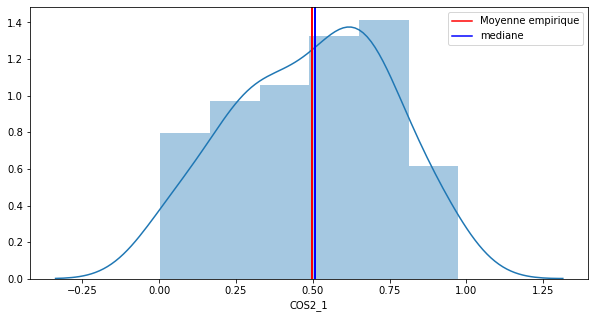

Statistics=15.391, p=0.000
L'echantillon ne semble pas Gaussien (seuil tolerance 5%, Hypothèse nulle H0 rejetée, normaltest.)
Statistics=0.834, p=0.000
L'echantillon ne semble pas Gaussien (seuil tolerance 5%, Hypothèse nulle H0 rejetée, test shapiro)
Statistics=0.500, p=0.000
L'echantillon ne semble pas Gaussien (seuil tolerance 5%, Hypothèse nulle H0 rejetée, test Kolmogorov-Smirnov.)


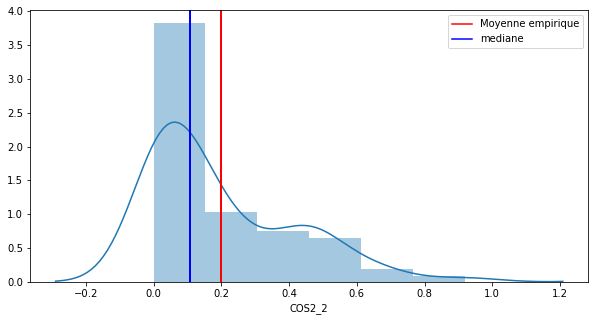

Statistics=6.008, p=0.050
L'echantillon ne semble pas Gaussien (seuil tolerance 5%, Hypothèse nulle H0 rejetée, normaltest.)
Statistics=0.949, p=0.007
L'echantillon ne semble pas Gaussien (seuil tolerance 5%, Hypothèse nulle H0 rejetée, test shapiro)
Statistics=0.603, p=0.000
L'echantillon ne semble pas Gaussien (seuil tolerance 5%, Hypothèse nulle H0 rejetée, test Kolmogorov-Smirnov.)


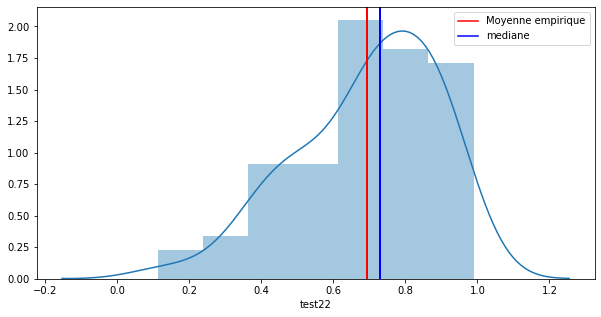

Statistics=436.259, p=0.000
L'echantillon ne semble pas Gaussien (seuil tolerance 5%, Hypothèse nulle H0 rejetée, normaltest.)
Statistics=1.000, p=1.000
L'echantillon semble Gaussien (seuil tolerance 5%, Hypothèse nulle H0 non rejetée, test shapiro)
Statistics=0.500, p=0.000
L'echantillon ne semble pas Gaussien (seuil tolerance 5%, Hypothèse nulle H0 rejetée, test Kolmogorov-Smirnov.)


C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\morestats.py:1673: UserWarning: Input data for shapiro has range zero. The results may not be accurate.
  warnings.warn("Input data for shapiro has range zero. The results "
C:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:288: UserWarning: Data must have variance to compute a kernel density estimate.
  warnings.warn(msg, UserWarning)


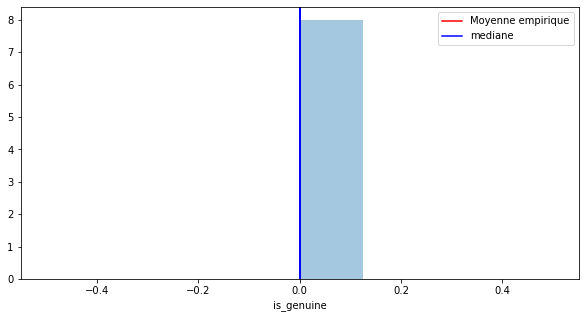

In [173]:
data = testos[testos['is_genuine'] == False].copy()
for column in data:
    norm(data[column])
    shap(data[column])
    kol(data[column])
    toto = sns.distplot(data[column]) # Stack these distributions together with different colors
    plt.axvline(data[column].mean(), color='r', linewidth=2)
    plt.axvline(data[column].median(), color='b', linewidth=2)
    plt.legend(handles=[mlines.Line2D([], [], color='red',markersize=15, label="Moyenne empirique"),mlines.Line2D([], [], color='blue',markersize=15, label=u"mediane")])
    plt.show()

Statistics=86.061, p=0.000
L'echantillon ne semble pas Gaussien (seuil tolerance 5%, Hypothèse nulle H0 rejetée, normaltest.)
Statistics=0.920, p=0.000
L'echantillon ne semble pas Gaussien (seuil tolerance 5%, Hypothèse nulle H0 rejetée, test shapiro)
Statistics=0.500, p=0.000
L'echantillon ne semble pas Gaussien (seuil tolerance 5%, Hypothèse nulle H0 rejetée, test Kolmogorov-Smirnov.)


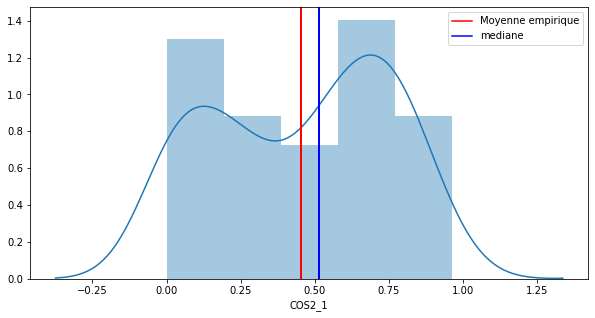

Statistics=20.053, p=0.000
L'echantillon ne semble pas Gaussien (seuil tolerance 5%, Hypothèse nulle H0 rejetée, normaltest.)
Statistics=0.817, p=0.000
L'echantillon ne semble pas Gaussien (seuil tolerance 5%, Hypothèse nulle H0 rejetée, test shapiro)
Statistics=0.500, p=0.000
L'echantillon ne semble pas Gaussien (seuil tolerance 5%, Hypothèse nulle H0 rejetée, test Kolmogorov-Smirnov.)


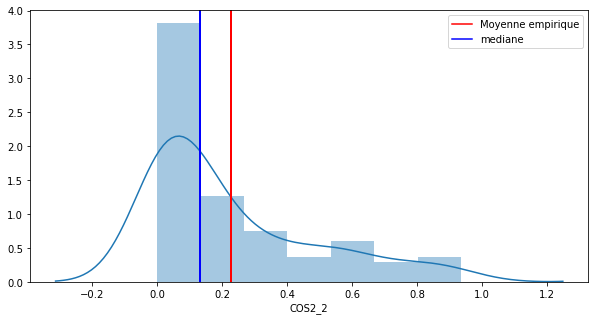

Statistics=13.121, p=0.001
L'echantillon ne semble pas Gaussien (seuil tolerance 5%, Hypothèse nulle H0 rejetée, normaltest.)
Statistics=0.902, p=0.000
L'echantillon ne semble pas Gaussien (seuil tolerance 5%, Hypothèse nulle H0 rejetée, test shapiro)
Statistics=0.548, p=0.000
L'echantillon ne semble pas Gaussien (seuil tolerance 5%, Hypothèse nulle H0 rejetée, test Kolmogorov-Smirnov.)


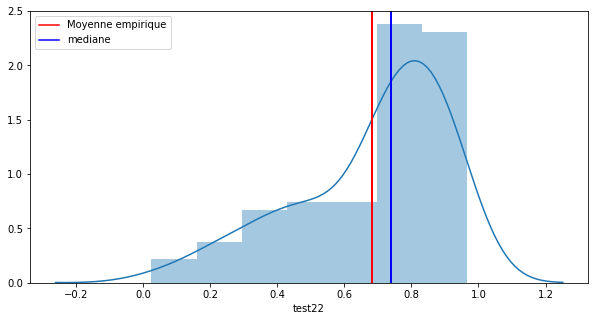

Statistics=498.152, p=0.000
L'echantillon ne semble pas Gaussien (seuil tolerance 5%, Hypothèse nulle H0 rejetée, normaltest.)
Statistics=1.000, p=1.000
L'echantillon semble Gaussien (seuil tolerance 5%, Hypothèse nulle H0 non rejetée, test shapiro)
Statistics=0.841, p=0.000
L'echantillon ne semble pas Gaussien (seuil tolerance 5%, Hypothèse nulle H0 rejetée, test Kolmogorov-Smirnov.)


C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\morestats.py:1673: UserWarning: Input data for shapiro has range zero. The results may not be accurate.
  warnings.warn("Input data for shapiro has range zero. The results "
C:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:288: UserWarning: Data must have variance to compute a kernel density estimate.
  warnings.warn(msg, UserWarning)


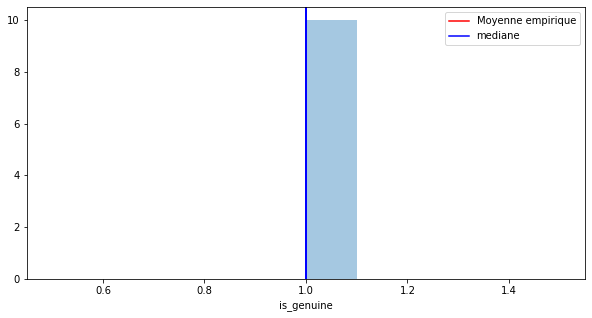

In [174]:
data = testos[testos['is_genuine'] == True].copy()
for column in data:
    norm(data[column])
    shap(data[column])
    kol(data[column])
    toto = sns.distplot(data[column]) # Stack these distributions together with different colors
    plt.axvline(data[column].mean(), color='r', linewidth=2)
    plt.axvline(data[column].median(), color='b', linewidth=2)
    plt.legend(handles=[mlines.Line2D([], [], color='red',markersize=15, label="Moyenne empirique"),mlines.Line2D([], [], color='blue',markersize=15, label=u"mediane")])
    plt.show()

In [176]:
# comparaison des echantillons
stat, p = ttest_ind(testos[testos['is_genuine'] == True]['test22'], testos[testos['is_genuine'] == False]['test22'])
print('Statistics=%.3f, p=%.3f' % (stat, p))
# interpret
alpha = 0.05
if p > alpha:
    print('Distributions identiques (nous ne rejetons pas H0)')
else:
    print('Distributions differentes (nous rejetons H0)')

Statistics=-0.382, p=0.703
Distributions identiques (nous ne rejetons pas H0)


In [181]:
X

array([[5.1, 3.5, 1.4, 0.2],
       [4.9, 3. , 1.4, 0.2],
       [4.7, 3.2, 1.3, 0.2],
       [4.6, 3.1, 1.5, 0.2],
       [5. , 3.6, 1.4, 0.2],
       [5.4, 3.9, 1.7, 0.4],
       [4.6, 3.4, 1.4, 0.3],
       [5. , 3.4, 1.5, 0.2],
       [4.4, 2.9, 1.4, 0.2],
       [4.9, 3.1, 1.5, 0.1],
       [5.4, 3.7, 1.5, 0.2],
       [4.8, 3.4, 1.6, 0.2],
       [4.8, 3. , 1.4, 0.1],
       [4.3, 3. , 1.1, 0.1],
       [5.8, 4. , 1.2, 0.2],
       [5.7, 4.4, 1.5, 0.4],
       [5.4, 3.9, 1.3, 0.4],
       [5.1, 3.5, 1.4, 0.3],
       [5.7, 3.8, 1.7, 0.3],
       [5.1, 3.8, 1.5, 0.3],
       [5.4, 3.4, 1.7, 0.2],
       [5.1, 3.7, 1.5, 0.4],
       [4.6, 3.6, 1. , 0.2],
       [5.1, 3.3, 1.7, 0.5],
       [4.8, 3.4, 1.9, 0.2],
       [5. , 3. , 1.6, 0.2],
       [5. , 3.4, 1.6, 0.4],
       [5.2, 3.5, 1.5, 0.2],
       [5.2, 3.4, 1.4, 0.2],
       [4.7, 3.2, 1.6, 0.2],
       [4.8, 3.1, 1.6, 0.2],
       [5.4, 3.4, 1.5, 0.4],
       [5.2, 4.1, 1.5, 0.1],
       [5.5, 4.2, 1.4, 0.2],
       [4.9, 3

Automatically created module for IPython interactive environment


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Confusion matrix, without normalization
[[50  0  0]
 [ 0 47  3]
 [ 0  1 49]]
Normalized confusion matrix
[[1.  0.  0. ]
 [0.  0.9 0.1]
 [0.  0.  1. ]]


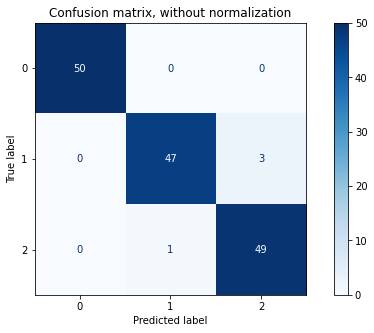

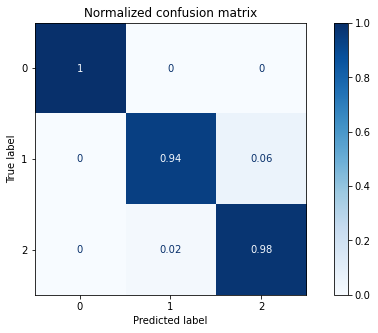

In [180]:
print(__doc__)

import numpy as np
import matplotlib.pyplot as plt

from sklearn import svm, datasets
#from sklearn.model_selection import train_test_split
from sklearn.metrics import plot_confusion_matrix

# import some data to play with
#iris = datasets.load_iris()
#X = iris.data
#y = iris.target
class_names = names

# Split the data into a training set and a test set
#X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

# Run classifier, using a model that is too regularized (C too low) to see
# the impact on the results
classifier = model.fit(X,y)

np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
titles_options = [("Confusion matrix, without normalization", None),
                  ("Normalized confusion matrix", 'true')]
for title, normalize in titles_options:
    disp = plot_confusion_matrix(classifier, X, y,
                                 display_labels=class_names,
                                 cmap=plt.cm.Blues,
                                 normalize=normalize)
    disp.ax_.set_title(title)

    print(title)
    print(disp.confusion_matrix)

plt.show()

In [ ]:
from sklearn.metrics import plot_confusion_matrix

In [ ]:
# Plot non-normalized confusion matrix
titles_options = [("Confusion matrix, without normalization", None),
                  ("Normalized confusion matrix", 'true')]
for title, normalize in titles_options:
    disp = plot_confusion_matrix(model, (F_data['is_genuine'],F_data['prediction']),
                                 display_labels=F_data['prediction'].values,
                                 cmap=plt.cm.Blues,
                                 normalize=normalize)
    #disp.ax_.set_title(title)

    #print(title)
    #print(disp.confusion_matrix)

plt.show()

In [ ]:
F_data.head()

In [ ]:
print(__doc__)

import numpy as np
import matplotlib.pyplot as plt

from sklearn import svm, datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import plot_confusion_matrix

# import some data to play with
iris = datasets.load_iris()
X = iris.data
y = iris.target
class_names = iris.target_names

# Split the data into a training set and a test set
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

# Run classifier, using a model that is too regularized (C too low) to see
# the impact on the results
classifier = svm.SVC(kernel='linear', C=0.01).fit(X_train, y_train)

np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
titles_options = [("Confusion matrix, without normalization", None),
                  ("Normalized confusion matrix", 'true')]
for title, normalize in titles_options:
    disp = plot_confusion_matrix(classifier, X_test, y_test,
                                 display_labels=class_names,
                                 cmap=plt.cm.Blues,
                                 normalize=normalize)
    disp.ax_.set_title(title)

    print(title)
    print(disp.confusion_matrix)

plt.show()

In [ ]:
#positionnement des individus dans le premier plan
fig, axes = plt.subplots(figsize=(12,12))
axes.set_xlim(-6,6) #même limites en abscisse
axes.set_ylim(-6,6) #et en ordonnée
#placement des étiquettes des observations
for i in range(n):
 plt.annotate(X.index[i],(coord[i,0],coord[i,1]))
#ajouter les axes
plt.plot([-6,6],[0,0],color='silver',linestyle='-',linewidth=1)
plt.plot([0,0],[-6,6],color='silver',linestyle='-',linewidth=1)
#affichage
plt.show()

Automatically created module for IPython interactive environment
Confusion matrix, without normalization
[[13  0  0]
 [ 0 10  6]
 [ 0  0  9]]
Normalized confusion matrix
[[1.   0.   0.  ]
 [0.   0.62 0.38]
 [0.   0.   1.  ]]


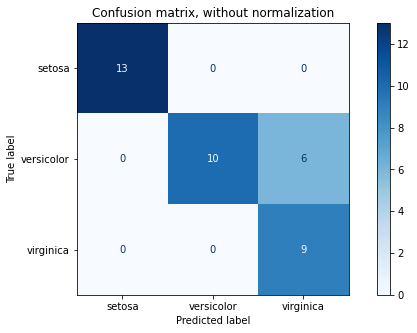

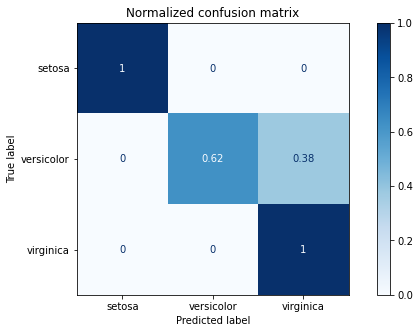

In [177]:
print(__doc__)

import numpy as np
import matplotlib.pyplot as plt

from sklearn import svm, datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import plot_confusion_matrix

# import some data to play with
iris = datasets.load_iris()
X = iris.data
y = iris.target
class_names = iris.target_names

# Split the data into a training set and a test set
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

# Run classifier, using a model that is too regularized (C too low) to see
# the impact on the results
classifier = svm.SVC(kernel='linear', C=0.01).fit(X_train, y_train)

np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
titles_options = [("Confusion matrix, without normalization", None),
                  ("Normalized confusion matrix", 'true')]
for title, normalize in titles_options:
    disp = plot_confusion_matrix(classifier, X_test, y_test,
                                 display_labels=class_names,
                                 cmap=plt.cm.Blues,
                                 normalize=normalize)
    disp.ax_.set_title(title)

    print(title)
    print(disp.confusion_matrix)

plt.show()

In [279]:
class_names

array(['setosa', 'versicolor', 'virginica'], dtype='<U10')

In [282]:
dataset.index

RangeIndex(start=0, stop=5, step=1)

In [288]:
y

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2])

In [284]:
iris.target_names

array(['setosa', 'versicolor', 'virginica'], dtype='<U10')

In [285]:
target_names

NameError: name 'target_names' is not defined

In [287]:
 iris

{'data': array([[5.1, 3.5, 1.4, 0.2],
        [4.9, 3. , 1.4, 0.2],
        [4.7, 3.2, 1.3, 0.2],
        [4.6, 3.1, 1.5, 0.2],
        [5. , 3.6, 1.4, 0.2],
        [5.4, 3.9, 1.7, 0.4],
        [4.6, 3.4, 1.4, 0.3],
        [5. , 3.4, 1.5, 0.2],
        [4.4, 2.9, 1.4, 0.2],
        [4.9, 3.1, 1.5, 0.1],
        [5.4, 3.7, 1.5, 0.2],
        [4.8, 3.4, 1.6, 0.2],
        [4.8, 3. , 1.4, 0.1],
        [4.3, 3. , 1.1, 0.1],
        [5.8, 4. , 1.2, 0.2],
        [5.7, 4.4, 1.5, 0.4],
        [5.4, 3.9, 1.3, 0.4],
        [5.1, 3.5, 1.4, 0.3],
        [5.7, 3.8, 1.7, 0.3],
        [5.1, 3.8, 1.5, 0.3],
        [5.4, 3.4, 1.7, 0.2],
        [5.1, 3.7, 1.5, 0.4],
        [4.6, 3.6, 1. , 0.2],
        [5.1, 3.3, 1.7, 0.5],
        [4.8, 3.4, 1.9, 0.2],
        [5. , 3. , 1.6, 0.2],
        [5. , 3.4, 1.6, 0.4],
        [5.2, 3.5, 1.5, 0.2],
        [5.2, 3.4, 1.4, 0.2],
        [4.7, 3.2, 1.6, 0.2],
        [4.8, 3.1, 1.6, 0.2],
        [5.4, 3.4, 1.5, 0.4],
        [5.2, 4.1, 1.5, 0.1],
  

In [76]:
d_i.sum()

NameError: name 'd_i' is not defined

In [115]:
#pd.set_option('display.max_rows',notes.shape[0]) #POUR AFFICHER TOUT LE DF
#notes

In [116]:
toto = notes[notes.columns[~notes.columns.isin(['is_genuine'])]].copy()
toto

,diagonal,height_left,height_right,margin_low,margin_up,length
0,171.81,104.86,104.95,4.52,2.89,112.83
1,171.67,103.74,103.70,4.01,2.87,113.29
2,171.83,103.76,103.76,4.40,2.88,113.84
3,171.80,103.78,103.65,3.73,3.12,113.63
4,172.05,103.70,103.75,5.04,2.27,113.55
...,...,...,...,...,...,...
165,172.11,104.23,104.45,5.24,3.58,111.78
166,173.01,104.59,104.31,5.04,3.05,110.91
167,172.47,104.27,104.10,4.88,3.33,110.68
168,171.82,103.97,103.88,4.73,3.55,111.87


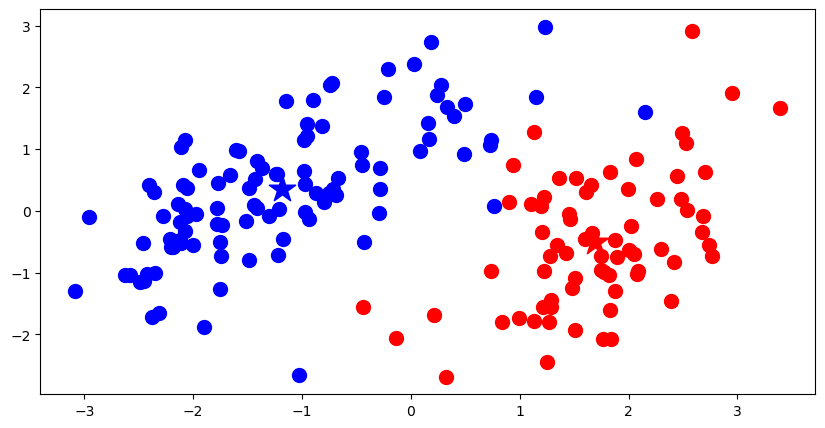

In [148]:
# Projection des individus
plt.figure(figsize=(10,5))
plt.scatter(F_data['F1'].loc[(F_data['is_genuine'] == 1 )].mean(), F_data['F2'].loc[(F_data['is_genuine'] == 1 )].mean(),s=400, color='blue',marker = '*', label = 'Centroid_True' )
plt.scatter(F_data['F1'].loc[(F_data['is_genuine'] == 0 )].mean(), F_data['F2'].loc[(F_data['is_genuine'] == 0 )].mean(),s=400, color='red',marker = '*', label = 'Centroid_False' )
plt.scatter(F_data['F1'].loc[(F_data['is_genuine'] == 1 )], F_data['F2'].loc[(F_data['is_genuine'] == 1 )], s = 100, color='blue',label = 'True' )
plt.scatter(F_data['F1'].loc[(F_data['is_genuine'] == 0 )], F_data['F2'].loc[(F_data['is_genuine'] == 0 )], s = 100, color='red', label = 'False' )
plt.draw()
#plt.savefig("2dim.jpg",bbox="tight")

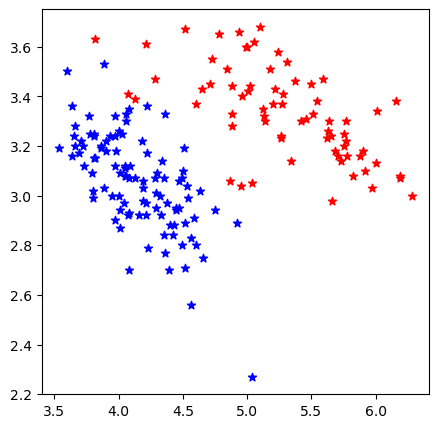

In [126]:
plt.scatter(notes[notes["is_genuine"] == True ]["margin_low"], notes[notes["is_genuine"] == True ]["margin_up"], color='blue',marker = '*', label = 'True' )
plt.scatter(notes[notes["is_genuine"] == False ]["margin_low"], notes[notes["is_genuine"] == False ]["margin_up"], color='red',marker = '*', label = 'False' )
#plt.scatter(notes[notes["is_genuine"] == True ]["margin_low"].mean(), notes[notes["is_genuine"] == True ]["margin_up"].mean(), color='blue',marker = '*',s=400, label = 'Centroid_9' )
#plt.scatter(notes[notes["is_genuine"] == False ]["margin_low"].mean(), notes[notes["is_genuine"] == False ]["margin_up"].mean(), color='red',marker = '*',s=400, label = 'Centroid_9' )

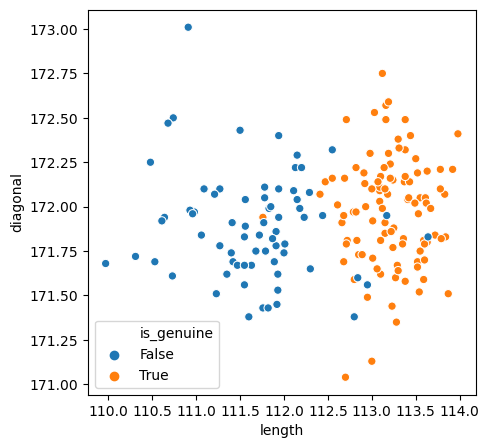

In [128]:
sns.scatterplot(x="length", y="diagonal", hue="is_genuine",data=notes)
plt.draw()

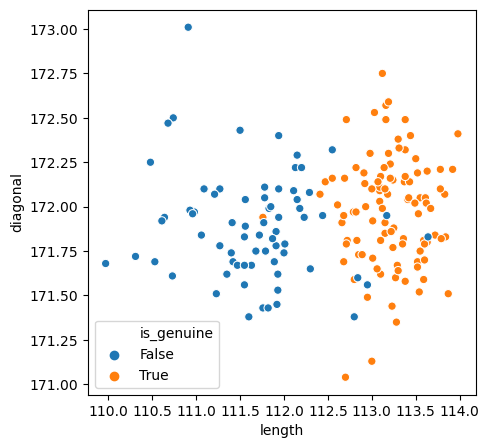

In [128]:
sns.scatterplot(x="length", y="diagonal", hue="is_genuine",data=notes)
plt.draw()

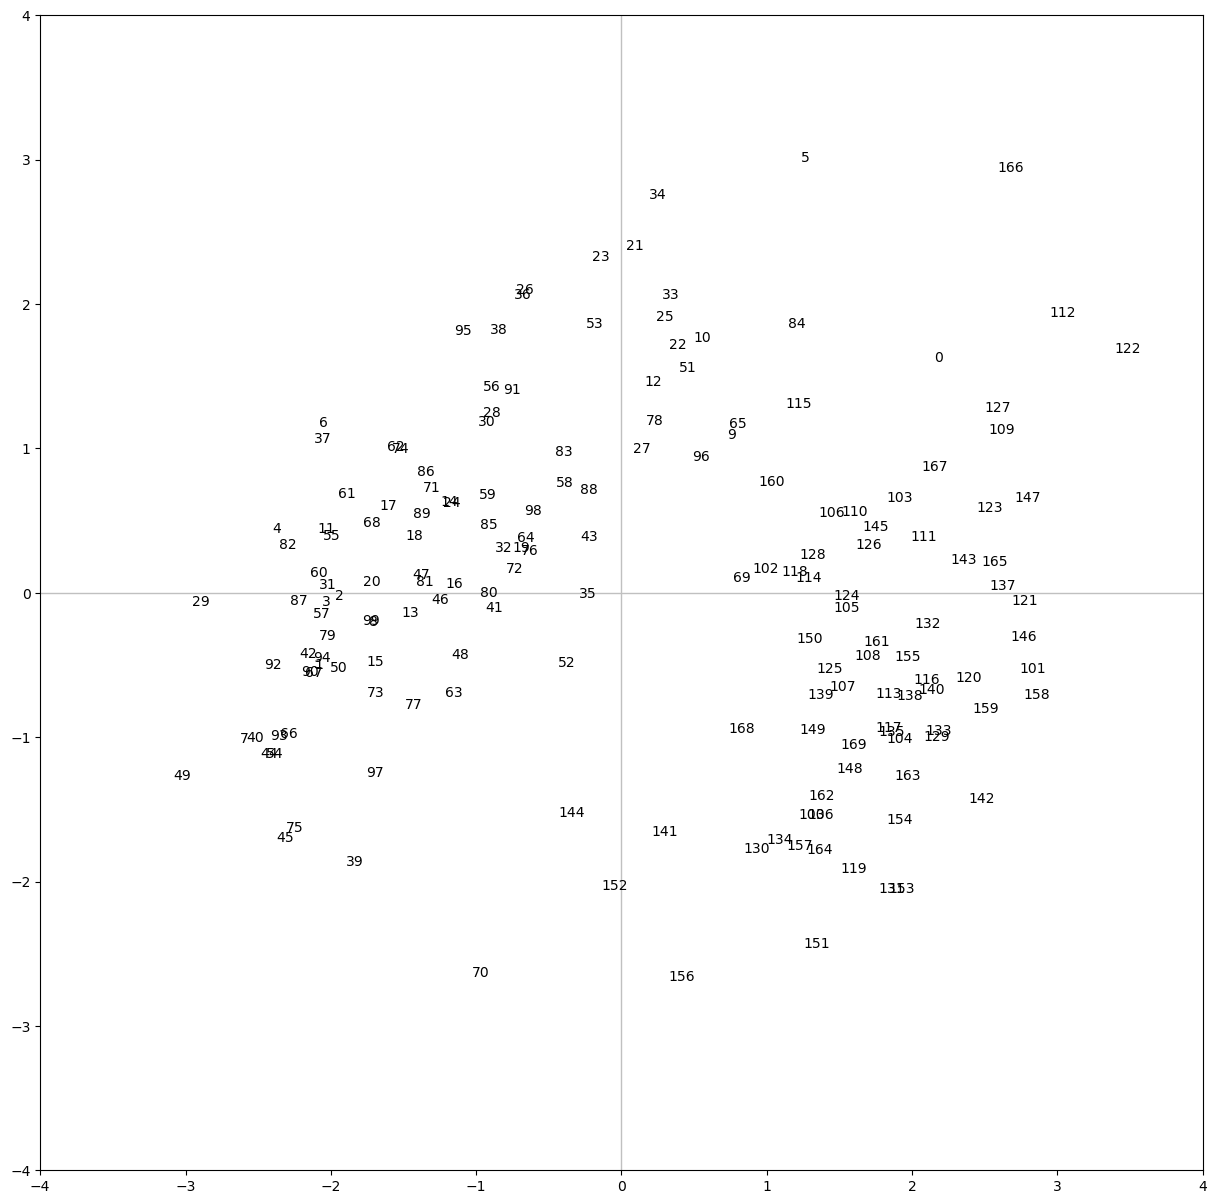

In [144]:
#positionnement des individus dans le premier plan
fig, axes = plt.subplots(figsize=(15,15))
axes.set_xlim(-4,4) #même limites en abscisse
axes.set_ylim(-4,4) #et en ordonnée
#placement des étiquettes des observations
n = X.shape[0]
for i in range(n):
 plt.annotate(names[i],(X_projected[i,0],X_projected[i,1]))
#ajouter les axes
plt.plot([-4,4],[0,0],color='silver',linestyle='-',linewidth=1)
plt.plot([0,0],[-4,4],color='silver',linestyle='-',linewidth=1)
#affichage
plt.draw()

In [123]:
notes_na = (notes.isna().sum()/len(notes))*100
notes_na

is_genuine      0.0
diagonal        0.0
height_left     0.0
height_right    0.0
margin_low      0.0
margin_up       0.0
length          0.0
dtype: float64

In [108]:
# Student's t-test
from scipy.stats import ttest_ind

In [109]:
#fonction de test shapiro
from scipy.stats import shapiro
def shap(dataset):
    # Shapiro-Wilk Test

    resultat = stat, p = shapiro(dataset)
    print('Statistics=%.3f, p=%.3f' % (stat, p))

    # interpretation
    alpha = 0.05 # seuil de tolerance 5%
    if p > alpha:
        print("L'echantillon semble Gaussien (seuil tolerance 5%, Hypothèse nulle H0 non rejetée, test shapiro)")
    else:
        print("L'echantillon ne semble pas Gaussien (seuil tolerance 5%, Hypothèse nulle H0 rejetée, test shapiro)")

    #resultat = st.shapiro(dataset)
    #return round(resultat[1],4)
    return

In [110]:
#fonction D’Agostino and Pearson’s test
def norm(dataset):
    # normal Test

    resultat = stat, p = st.normaltest(dataset)
    print('Statistics=%.3f, p=%.3f' % (stat, p))

    # interpretation
    alpha = 0.05 # seuil de tolerance 5%
    if p > alpha:
        print("L'echantillon semble Gaussien (seuil tolerance 5%, Hypothèse nulle H0 non rejetée, normaltest.)")
    else:
        print("L'echantillon ne semble pas Gaussien (seuil tolerance 5%, Hypothèse nulle H0 rejetée, normaltest.)")

    return

In [111]:
#fonction de Kolmogorov-Smirnov test
def kol(dataset):
    

    resultat = stat, p = st.kstest((dataset),'norm')
    print('Statistics=%.3f, p=%.3f' % (stat, p))

    # interpretation
    alpha = 0.05 # seuil de tolerance 5%
    if p > alpha:
        print("L'echantillon semble Gaussien (seuil tolerance 5%, Hypothèse nulle H0 non rejetée, test Kolmogorov-Smirnov.)")
    else:
        print("L'echantillon ne semble pas Gaussien (seuil tolerance 5%, Hypothèse nulle H0 rejetée, test Kolmogorov-Smirnov.)")

    return

In [112]:
#fonction de test shapiro 
def shap_test(dataset):
    # Shapiro-Wilk Test
    resultat = st.shapiro(dataset)
    return round(resultat[1],3)

#fonction de test Kolmogorov-Smirnov 
def kol_test(dataset):
    # Kolmogorov-Smirnov Test
    resultat = st.kstest((dataset),'norm')
    return round(resultat[1],3)

#fonction de normaltest 
def norm_test(dataset):
    # Shapiro-Wilk Test
    resultat = st.normaltest(dataset)
    return round(resultat[1],3)

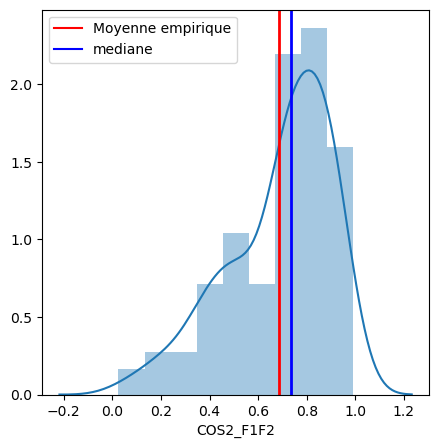

In [142]:
#qualité de représentation des individus - COS2
toto = sns.distplot(testo['COS2_F1F2']) # Stack these distributions together with different colors
plt.axvline(testo['COS2_F1F2'].mean(), color='r', linewidth=2)
plt.axvline(testo['COS2_F1F2'].median(), color='b', linewidth=2)
plt.legend(handles=[mlines.Line2D([], [], color='red',markersize=15, label="Moyenne empirique"),mlines.Line2D([], [], color='blue',markersize=15, label=u"mediane")])
plt.draw()
plt.savefig("représentation_individus.jpg",bbox="tight")

In [146]:
np.count_nonzero(y_kmeans == 0)

77

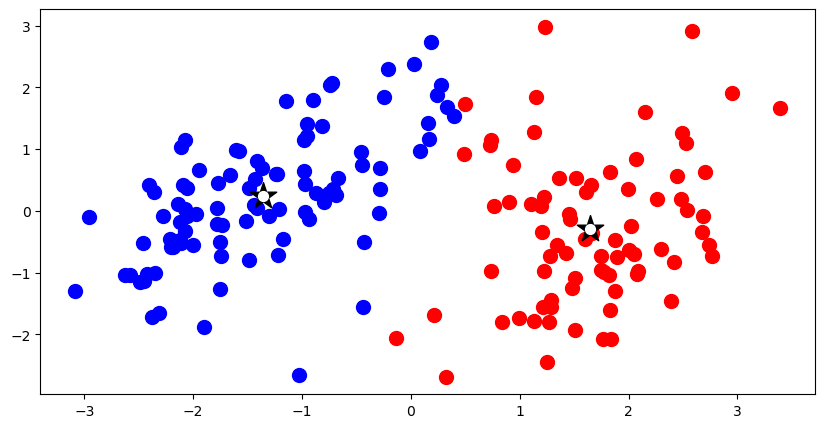

In [149]:
plt.rcParams["figure.figsize"]=[10,5]

plt.scatter(X_projected[y_kmeans == 0, 0], X_projected[y_kmeans == 0, 1], s = 100, c = 'red', label = 'Cluster 0')
plt.scatter(X_projected[y_kmeans == 1, 0], X_projected[y_kmeans == 1, 1], s = 100, c = 'blue', label = 'Cluster 1')
plt.scatter(X_projected[y_kmeans == 1, 0].mean(), X_projected[y_kmeans == 1, 1].mean(), color='k',marker = '*',s=400, label = 'Centroid_0' )
plt.scatter(X_projected[y_kmeans == 0, 0].mean(), X_projected[y_kmeans == 0, 1].mean(), color='k',marker = '*',s=400, label = 'Centroid_1' )
plt.scatter(C_projected[:, 0], C_projected[:, 1], s = 50, c = 'w', label = 'Centroids_all')
#plt.title('Clusters de demandeur_credit')
#plt.xlabel('epargne en millier')
#plt.ylabel('score_bank')
#plt.legend()
plt.draw()
#plt.savefig("kmeans.jpg",bbox="tight")

In [201]:
#notes[notes.columns[~notes.columns.isin(['is_genuine'])]].copy()
F_data[F_data.columns[~F_data.columns.isin(['F1','F2'])]].copy()

,diagonal,height_left,height_right,margin_low,margin_up,length,KM_genuine,is_genuine,vrai_%,prediction
0,171.81,104.86,104.95,4.52,2.89,112.83,0,1,63.71,1
1,171.67,103.74,103.70,4.01,2.87,113.29,1,1,99.38,1
2,171.83,103.76,103.76,4.40,2.88,113.84,1,1,99.36,1
3,171.80,103.78,103.65,3.73,3.12,113.63,1,1,99.80,1
4,172.05,103.70,103.75,5.04,2.27,113.55,1,1,96.97,1
...,...,...,...,...,...,...,...,...,...,...
165,172.11,104.23,104.45,5.24,3.58,111.78,0,0,1.65,0
166,173.01,104.59,104.31,5.04,3.05,110.91,0,0,0.63,0
167,172.47,104.27,104.10,4.88,3.33,110.68,0,0,0.71,0
168,171.82,103.97,103.88,4.73,3.55,111.87,0,0,17.61,0


In [174]:
from sklearn.metrics import confusion_matrix
confusion = confusion_matrix(F_data['is_genuine'],F_data['KM_genuine'])
print(confusion)

[[69  1]
 [ 8 92]]


In [174]:
from sklearn.metrics import confusion_matrix
confusion = confusion_matrix(F_data['is_genuine'],F_data['KM_genuine'])
print(confusion)

[[69  1]
 [ 8 92]]


In [152]:
df.y_kmeans.value_counts()

1    93
0    77
Name: y_kmeans, dtype: int64

In [176]:
(F_data['is_genuine'] == F_data['KM_genuine']).sum()/len(F_data)

0.9470588235294117

In [157]:
(F_data['is_genuine'] == F_data['KM_genuine']).sum()/len(F_data)

0.9470588235294117

In [233]:
F_data['is_genuine'].value_counts()

1    100
0     70
Name: is_genuine, dtype: int64

In [ ]:
dataset = toto[toto.columns[~toto.columns.isin(['is_genuine'])]].copy

la moyenne de la colonne  is_genuine 0.5882352941176471
la mediane de la colonne  is_genuine 1.0
Ecart-type:
 0.4921529567847503


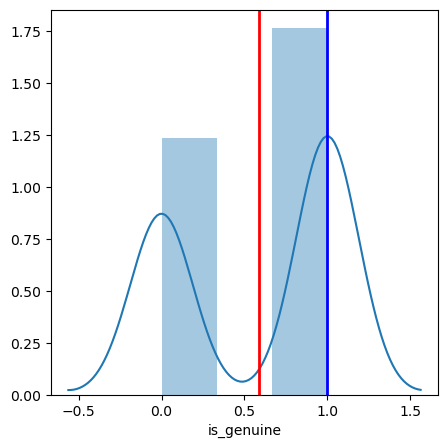

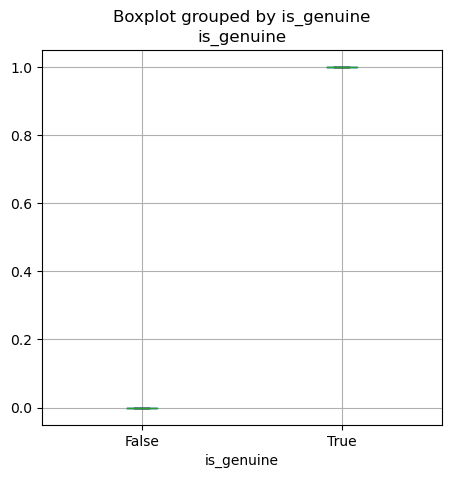

la moyenne de la colonne  diagonal 171.94058823529414
la mediane de la colonne  diagonal 171.945
Ecart-type:
 0.3048677743901313


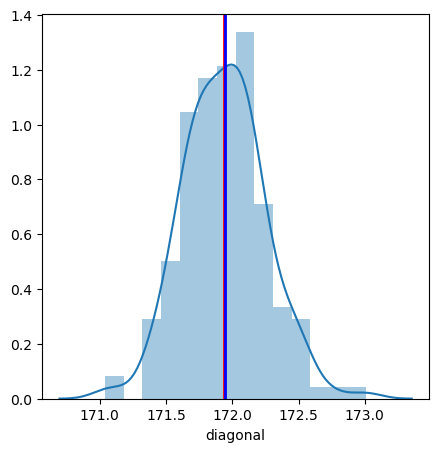

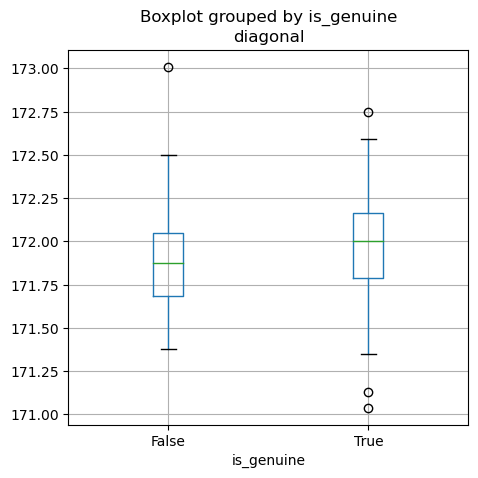

la moyenne de la colonne  height_left 104.0663529411764
la mediane de la colonne  height_left 104.055
Ecart-type:
 0.29730692027648925


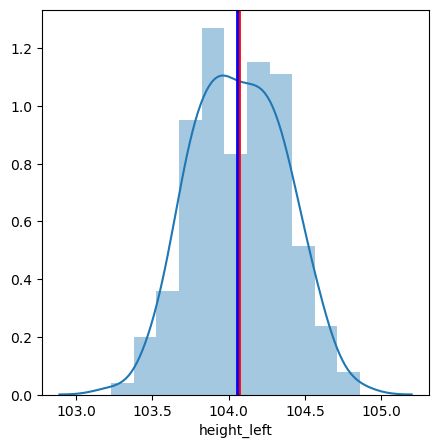

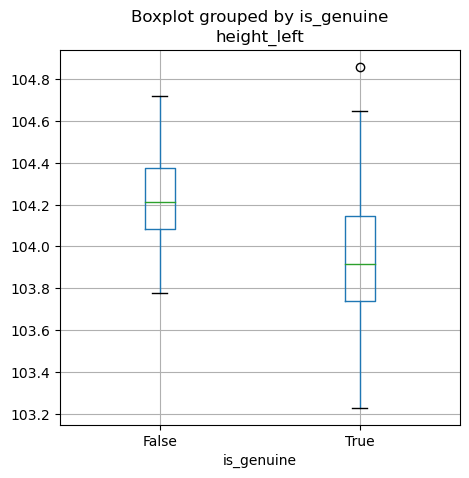

la moyenne de la colonne  height_right 103.92811764705884
la mediane de la colonne  height_right 103.95
Ecart-type:
 0.33000532657963905


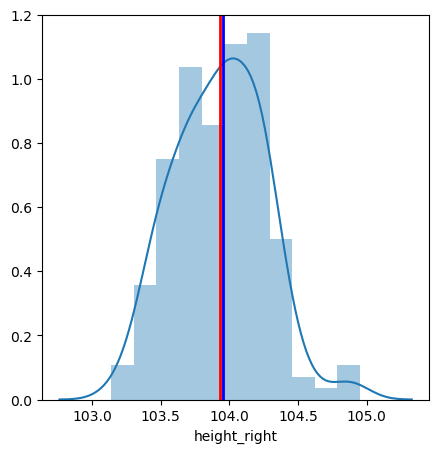

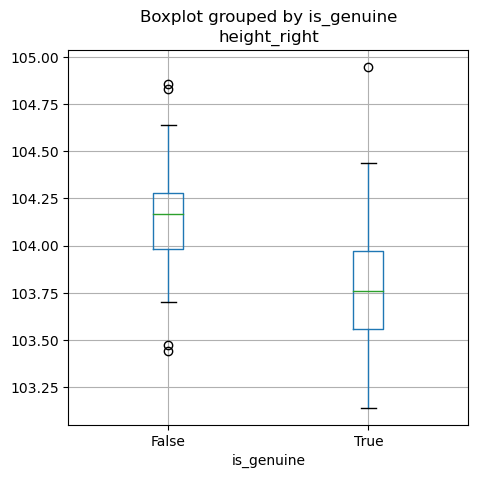

la moyenne de la colonne  margin_low 4.612117647058824
la mediane de la colonne  margin_low 4.45
Ecart-type:
 0.7000346111067688


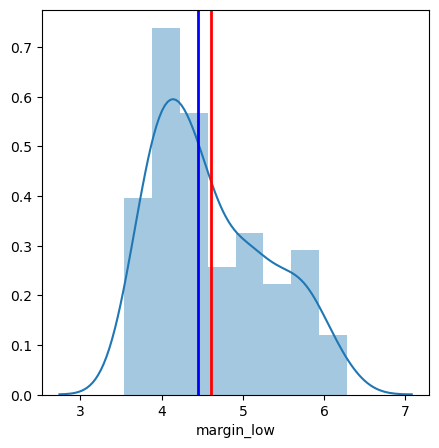

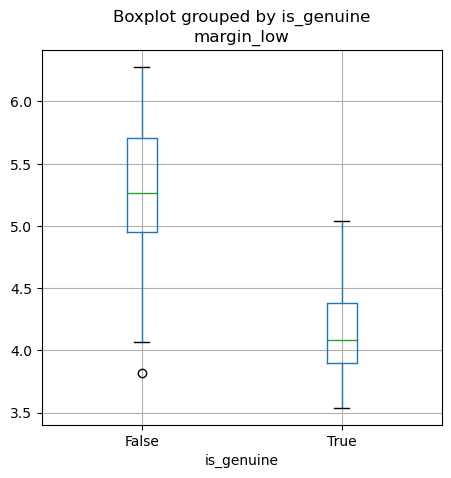

la moyenne de la colonne  margin_up 3.170411764705883
la mediane de la colonne  margin_up 3.17
Ecart-type:
 0.23566515598183932


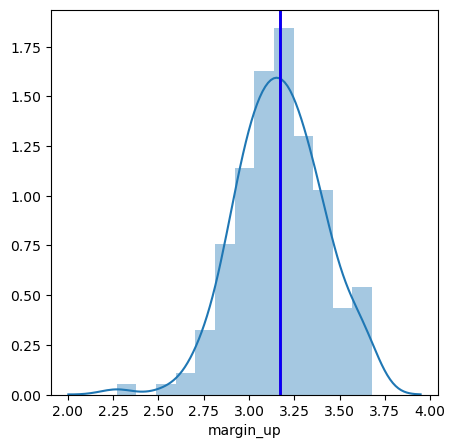

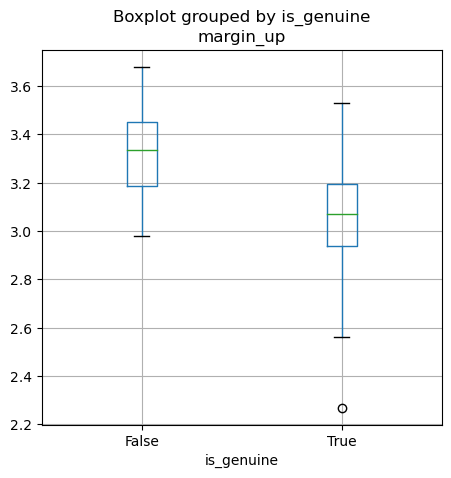

la moyenne de la colonne  length 112.57041176470587
la mediane de la colonne  length 112.845
Ecart-type:
 0.9217249531575873


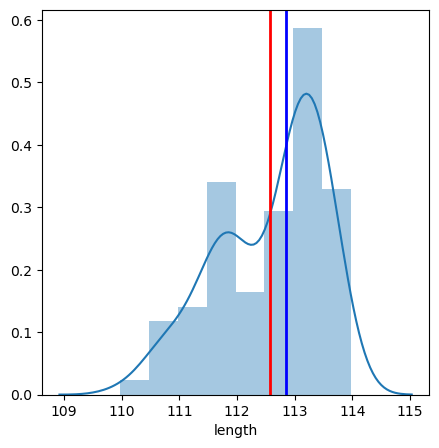

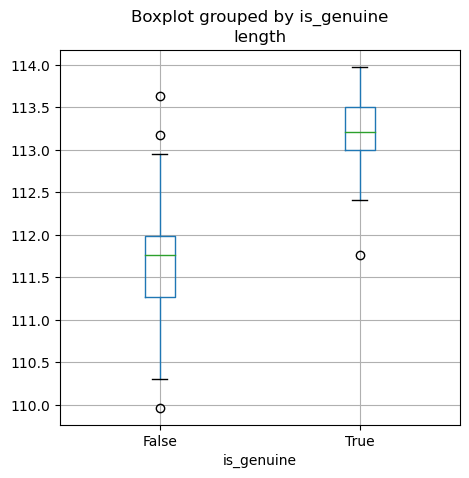

In [15]:
for column in notes.iloc[:,0:7]:
    print("la moyenne de la colonne ",column, notes[column].mean())
    print("la mediane de la colonne ",column, notes[column].median())
    print("Ecart-type:\n",notes[column].std(ddof=0))
    sns.distplot(notes[column])
    plt.axvline(notes[column].mean(), color='r', linewidth=2)
    plt.axvline(notes[column].median(), color='b', linewidth=2)
    #plt.legend(handles=[mlines.Line2D([], [], color='red',markersize=15, label="Moyenne empirique"),mlines.Line2D([], [], color='blue',markersize=15, label=u"mediane")])
    plt.show()
    notes.boxplot(column=[column],by="is_genuine")
    plt.show()

In [10]:
def ana(toto):
    dataset = toto[['diagonal', 'height_left', 'height_right', 'margin_low', 'margin_up', 'length']].copy()
    print ("La taille de notre tableau de mesures des billets est de : ", dataset.shape," (lignes,colonnes).")           
    print ("--------------------------------------------------------------------")
    for column in dataset:
        print("La moyenne de la colonne ",column," est: ", round(dataset[column].mean(),2),"mm.")
        print("La médiane de la colonne ",column," est: ", round(dataset[column].median(),2),"mm.")
        #print("Le mode de la colonne ",column," est: ", dataset[column].mode())
        print("L'ecart type de la colonne ",column," est: ", round(dataset[column].std(ddof=1),2),"mm.")
        print("La variance de la colonne ",column," est: ", round(dataset[column].var(ddof=1),2),"mm.")
        #print("Le skewness empirique de la colonne ",column," est: ", dataset[column].skew())
        #print("Le kurtosis empirique de la colonne ",column," est: ", dataset[column].kurtosis())
        print("La valeur maximum de la colonne",column," est: ",dataset[column].max())
        print("La valeur minimum de la colonne",column," est: ",dataset[column].min())
        #dataset[column].hist() # Crée l'histogramme
        #plt.draw()
        print ("--------------------------------------------------------------------")
ana(notes)

La taille de notre tableau de mesures des billets est de :  (170, 6)  (lignes,colonnes).
--------------------------------------------------------------------
La moyenne de la colonne  diagonal  est:  171.94 mm.
La médiane de la colonne  diagonal  est:  171.94 mm.
L'ecart type de la colonne  diagonal  est:  0.31 mm.
La variance de la colonne  diagonal  est:  0.09 mm.
La valeur maximum de la colonne diagonal  est:  173.01
La valeur minimum de la colonne diagonal  est:  171.04
--------------------------------------------------------------------
La moyenne de la colonne  height_left  est:  104.07 mm.
La médiane de la colonne  height_left  est:  104.06 mm.
L'ecart type de la colonne  height_left  est:  0.3 mm.
La variance de la colonne  height_left  est:  0.09 mm.
La valeur maximum de la colonne height_left  est:  104.86
La valeur minimum de la colonne height_left  est:  103.23
--------------------------------------------------------------------
La moyenne de la colonne  height_right  est: 

In [29]:
dataset = ciit.copy()
for column in dataset:
    print("La somme totale de la colonne",column," est: ", dataset[column].sum())
    print("La moyenne de la colonne",column," est: ", round(dataset[column].mean(),2))
    print("La médiane de la colonne",column," est: ", round(dataset[column].median(),2))
    print("L'ecart type de la colonne",column," est: ", round(dataset[column].std(ddof=1),2))
    print("La variance de la colonne",column," est: ", round(dataset[column].var(ddof=1),2))
    print("La valeur maximum de la colonne",column," est: ",dataset[column].max())
    print("La valeur minimum de la colonne",column," est: ",dataset[column].min())

La somme totale de la colonne contrib_it  est:  1020.0
La moyenne de la colonne contrib_it  est:  6.0
La médiane de la colonne contrib_it  est:  5.46
L'ecart type de la colonne contrib_it  est:  3.4
La variance de la colonne contrib_it  est:  11.59
La valeur maximum de la colonne contrib_it  est:  20.625650348042868
La valeur minimum de la colonne contrib_it  est:  0.8139288445533632


In [55]:
F_data[F_data['is_genuine'] != (model.predict_proba(X)[:,1] >= 0.5)]

,diagonal,height_left,height_right,margin_low,margin_up,length,F1,F2,KM_genuine,is_genuine,vrai_%,prediction
69,171.94,104.11,104.16,4.08,3.35,111.76,0.765438,0.073366,0,1,48.47,0
102,171.94,104.21,104.10,4.28,3.47,112.23,0.901311,0.141600,0,0,56.07,1


In [134]:
print("Pourcentage de similitude apres test de l'algorithme sur les données d'entrainement : ",accuracy_score(F_data['prediction'].values, F_data['is_genuine'].values)*100,'%')

Pourcentage de similitude apres test de l'algorithme sur les données d'entrainement :  98.82352941176471 %
